# Welcome to your anomaly detection tool for the PLT detector at CMS! If running this on jupyter notebook, make sure to run this first cell to ensure adtk is mounted in the correct path. Otherwise skip to cell 2 to run the function to load in the hd5 file as well as mount all necessary packages.

In [1]:
import site
import sys

user_site = site.USER_SITE
if user_site not in sys.path:
    sys.path.append(user_site)
    print(f"Added {user_site} to Python path.")
print("Updated Python path:", sys.path)

try:
    from adtk.data import validate_series
    print("adtk module imported successfully.")
except ModuleNotFoundError:
    print("ModuleNotFoundError: No module named 'adtk'")

Added /eos/user/k/kream/.local/lib/python3.9/site-packages to Python path.
Updated Python path: ['/eos/home-i01/k/kream/SWAN_projects/plt', '/cvmfs/sft.cern.ch/lcg/releases/condor/23.0.2-36b2d/x86_64-el9-gcc13-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/usr/local/lib/swan/nb_term_lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/cvm

## Load in packages.

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables
from adtk.data import validate_series
from adtk.detector import ThresholdAD, LevelShiftAD
from datetime import datetime
import math
import warnings
import os
import scipy.optimize as opt  
from IPython.display import display_html
from IPython.core.display import display, HTML
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
happy_message = ["Gee whiskers!", "As Post Malone said - Congratulations!", "Hats off to you!", "Perfect time for a coffee break!", "Cheers, mate!", "Here's a gold star for you!", "You're doing great sweetie!", "Slay queen!",
                "Pat yourself on the back!", "We did it, we did it, we did it yay!", "Look at you go!", "Wave your hands in the air like you just don't care!", "It's a party in the USA!", "Aye yay captain!", "Skippidy doo dah day!",
                "You go girl!", "You just bopped to the top!", "Skip to my loo my darling!", "Yahtzee!", "Victory lap!", "You just passed go - collect $200!"]

## Run the code below to load in the data table and create respective dataframes.
## For the adtk named dataframes, we define them to hold only the date-time and luminosity values to apply the anomaly detection algorithm. Make sure before running the algorithm the data is in this format, where the date-time is also the index of the dataframe. 

In [4]:
import pathlib
#list(pathlib.Path('/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/').glob('*.pkl'))

In [5]:
fill_number = 9059
hd5 = pd.read_pickle(f'/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/{fill_number}.pkl')
hd5_cleaned = hd5.dropna()
rename_dict = {f'pltaggzero_data_{i:02}': f'pltaggzero_{i}' for i in range(16)}
pltagg_columns = [f'pltaggzero_{i}' for i in range(16)]
hd5_cleaned = hd5_cleaned.rename(columns=rename_dict)
hd5_cleaned = hd5_cleaned.loc[hd5_cleaned['beam_status'] == "STABLE BEAMS"]
hd5_cleaned = hd5_cleaned[(hd5_cleaned[pltagg_columns] >= 0).all(axis=1)]
hd5_cleaned = hd5_cleaned[(hd5_cleaned['hfetlumi_avgraw'] >= 0) & (hd5_cleaned['hfetlumi_avgraw'].notna())]
hd5_cleaned = hd5_cleaned[(hd5_cleaned['bcm1flumi_avgraw'] >= 0) & (hd5_cleaned['bcm1flumi_avgraw'].notna())]


channels = range(16)
ch_data = [hd5_cleaned[['nbnum', 'fillnum', 'runnum', 'lsnum', 'date_time', f'pltaggzero_{ch}', 'hfetlumi_avgraw', 'bcm1flumi_avgraw']].rename(columns={f'pltaggzero_{ch}': 'lumi'}) for ch in channels]

def ch_ratio(hd5: pd.DataFrame, ch: int, ref_thr: float = 0.1) -> pd.DataFrame:
    if f'pltaggzero_{ch}' not in hd5.columns:
        print(f"Column 'pltaggzero_{ch}' does not exist.")
        return pd.DataFrame()  
    
    ch_data = hd5[hd5[f'pltaggzero_{ch}'] > 0].copy() 
    other_channels = [f'pltaggzero_{other_ch}' for other_ch in range(16) if other_ch != ch]
    ch_data['lumi_ref'] = hd5[other_channels].median(axis=1)
    ch_data = ch_data[ch_data['lumi_ref'] >= ref_thr * ch_data['lumi_ref'].mean()].reset_index(drop=True)
    ch_data['ratio'] = ch_data[f'pltaggzero_{ch}'] / ch_data['lumi_ref']
    return ch_data

ch_ratios = [ch_ratio(hd5=hd5_cleaned, ch=ch, ref_thr=0.1) for ch in channels]
lumi_data = [ch_data[ch]['lumi'] for ch in channels]
dt_data = [ch_data[ch]['date_time'] for ch in channels]
hf_data = hd5_cleaned['hfetlumi_avgraw']
bcm1f_data = hd5_cleaned['bcm1flumi_avgraw']

df_data = pd.Series(ch_data)
df_ratio = pd.Series(ch_ratios).dropna()
df_ratio_adtk = pd.Series([ch_ratios[ch]['ratio'] for ch in channels])
df_hf = pd.Series(hf_data)
df_bcm1f = pd.Series(bcm1f_data)

lumi_df = pd.DataFrame(lumi_data).T
lumi_column_names = [f'lumi{i}' for i in channels]
lumi_df.columns = lumi_column_names

dt_df = pd.DataFrame(dt_data).T
dt_column_names = [f'date-time{i}' for i in channels]
dt_df.columns = dt_column_names

adtk_df_ratio = pd.concat([dt_df, df_ratio_adtk], axis=1)
adtk_df = pd.concat([pd.DataFrame({f'lumi_{i}': lumi_data[i], f'date-time_{i}': dt_data[i]}) for i in channels], axis=1)

titles = [f'ch{ch} lumi' for ch in channels]
titles_r = [f'ch{ch}/all' for ch in channels]

hd5_cleaned

,fillnum,runnum,lsnum,nbnum,hfetlumi_avgraw,hfetlumi_avg,hfetlumi_bxraw,hfetlumi_bx,remuslumi_avgraw,remuslumi_avg,...,pltlumizero_avg,pltlumizero_bxraw,pltlumizero_bx,hfoclumi_avgraw,hfoclumi_avg,hfoclumi_bxraw,hfoclumi_bx,tcds_cmson,tcds_deadfrac,date_time
7,9059,370522,45,32,3686.490723,12188.523438,3686.507568,12188.572266,1243.921875,12217.178711,...,12239.104492,346.876465,12239.128906,1069.853638,12227.396484,1069.924561,12228.206055,1.0,0.012186,2023-07-11 23:54:54.094326528+00:00
8,9059,370522,45,36,3685.802246,12186.239258,3685.723633,12185.980469,1244.362549,12221.506836,...,12240.102539,346.889893,12240.110352,1069.780762,12226.550781,1069.836182,12227.196289,1.0,0.012239,2023-07-11 23:54:55.554875136+00:00
9,9059,370522,45,40,3685.422363,12184.971680,3685.317139,12184.636719,1238.194214,12160.923828,...,12241.540039,346.946503,12241.583984,1069.680908,12225.420898,1069.762207,12226.351562,1.0,0.012137,2023-07-11 23:54:57.016437504+00:00
10,9059,370522,45,44,3684.874023,12183.175781,3684.666992,12182.486328,1238.634766,12165.250977,...,12239.232422,346.875732,12239.263672,1069.454102,12222.836914,1069.503662,12223.394531,1.0,0.012166,2023-07-11 23:54:58.477097216+00:00
11,9059,370522,45,48,3684.544189,12182.066406,3684.455566,12181.787109,1238.634766,12165.250977,...,12237.087891,346.811035,12237.107422,1069.504761,12223.400391,1069.543945,12223.855469,1.0,0.012087,2023-07-11 23:54:59.941965312+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,9059,370522,379,56,0.000000,0.000000,-0.101501,-0.335589,3.641815,35.768089,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019923,-0.227704,0.0,1.000000,2023-07-12 02:04:48.716673792+00:00
5358,9059,370522,379,60,0.000000,0.000000,-0.129461,-0.428032,3.641815,35.768089,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000830,-0.009485,0.0,1.000000,2023-07-12 02:04:50.178763776+00:00
5359,9059,370522,379,64,0.000000,0.000000,-0.061708,-0.204024,4.082413,40.095417,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003707,-0.042362,0.0,1.000000,2023-07-12 02:04:51.644437504+00:00
5360,9059,370522,380,4,0.000000,0.000000,-0.048154,-0.159208,6.725994,66.059349,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003148,-0.035980,0.0,1.000000,2023-07-12 02:04:53.100875008+00:00


In [6]:
channels_failed = [6, 8, 9] 
channels_good = [ch for ch in channels if ch not in channels_failed]

all_lumi_values = []
for ch in channels_good:
    all_lumi_values.extend(df_data[ch]['lumi'].values)

median_channel_series = pd.Series(all_lumi_values).median()
channel_median_diff = {}

for ch in channels_good:
    difference_plt_median = np.abs(df_data[ch]['lumi'] - median_channel_series)
    median_diff = difference_plt_median.median()
    channel_median_diff[ch] = median_diff 

closest_channel = min(channel_median_diff, key=channel_median_diff.get)

print(f"The reference channel for fill {fill_number} is Channel {closest_channel}.")
reference = [closest_channel]

The reference channel for fill 9059 is Channel 14.


## Now plot all individual channels and all ratio channels with their respective histograms to see what the fill looks like. One thing we care about is the distribution of the ratio channel histogram for our channel selection: if the histogram shape is bad, keep it as a possibility to eliminate said channel.

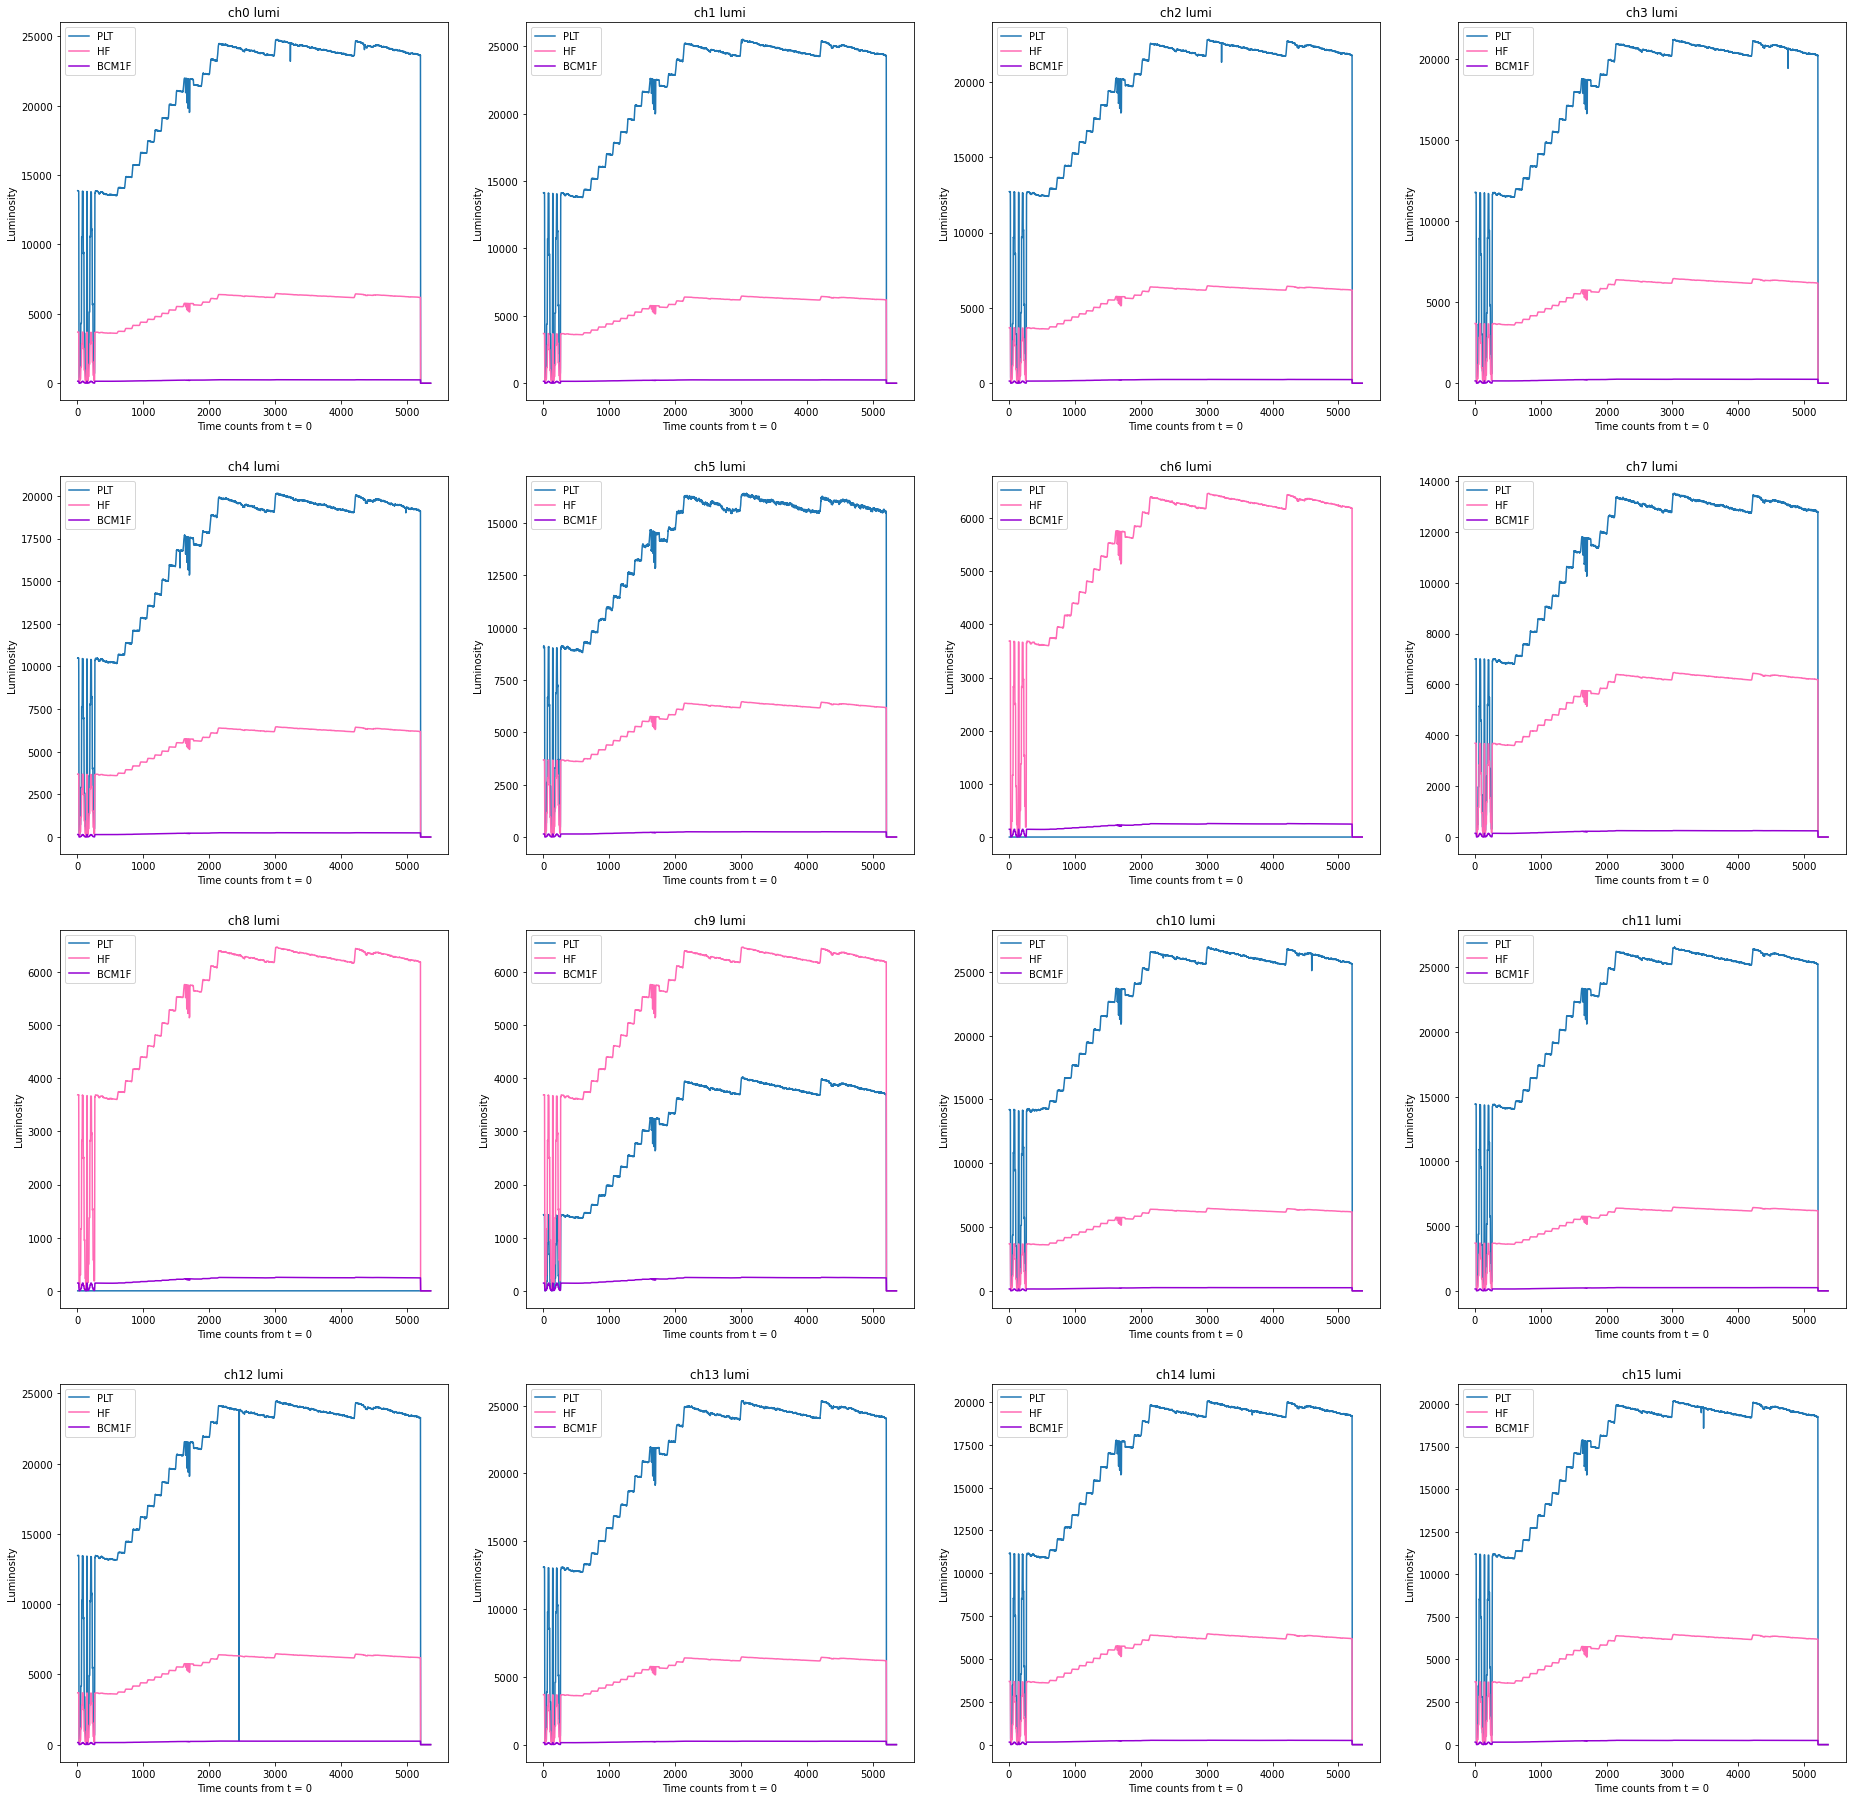

In [103]:
fig, axes = plt.subplots(4,4, figsize=(32,32))

for i, ax in enumerate(axes.flatten()):
    df_data[i].lumi.plot(ax = ax, title = titles[i], label = 'PLT')
    ax.plot(df_hf, color = 'hotpink', label = 'HF')
    ax.plot(df_bcm1f, color = 'darkviolet', label = 'BCM1F')
    ax.set_xlabel("Time counts from t = 0")
    ax.set_ylabel("Luminosity")
    ax.legend(loc = 'best')
    
plt.show() 

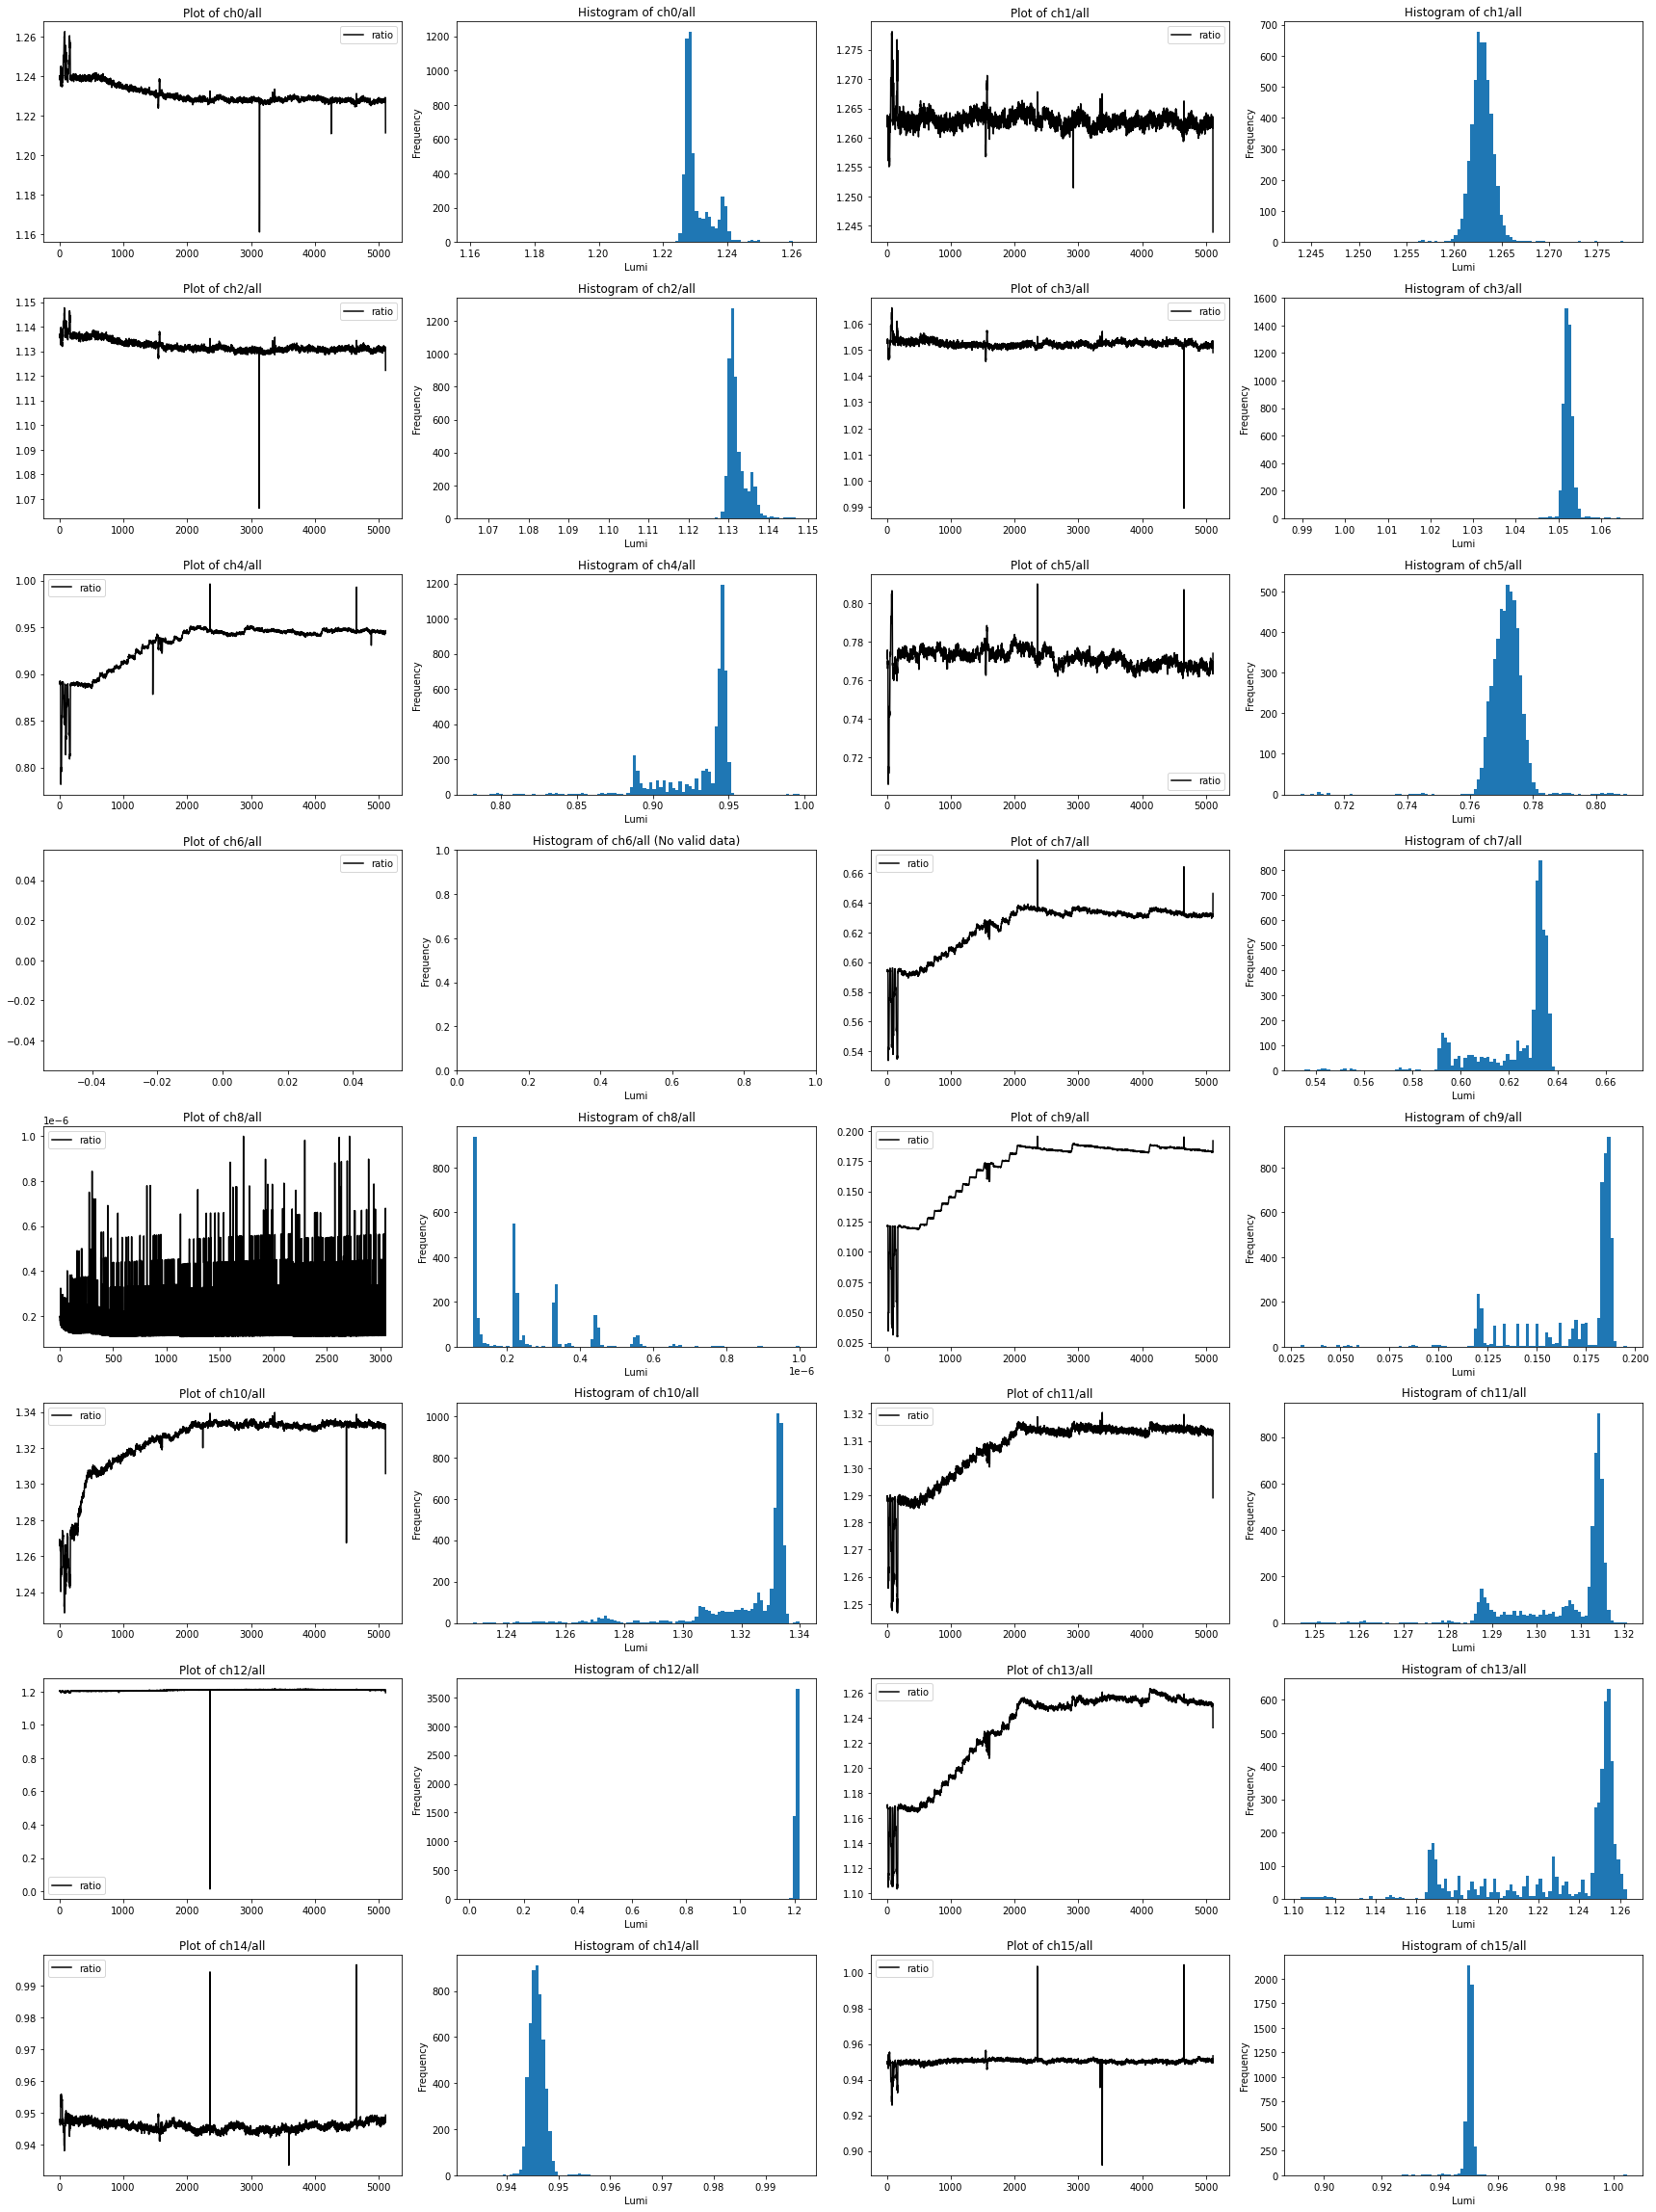

In [104]:
fig, axes = plt.subplots(8, 4, figsize=(24, 32))

for i, ax in enumerate(axes.flatten()):
    index = i // 2  
    if i % 2 == 0:
        df_ratio[index].plot(y='ratio', color='black', ax=ax)
        ax.set_title(f"Plot of {titles_r[index]}")
    else:
        valid_data = df_ratio[index]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
        
        if not valid_data.empty:
            ax.hist(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
            ax.set_title(f"Histogram of {titles_r[index]}")
            ax.set_xlabel("Lumi")
            ax.set_ylabel("Frequency")
        else:
            ax.set_title(f"Histogram of {titles_r[index]} (No valid data)")
            ax.set_xlabel("Lumi")
            ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

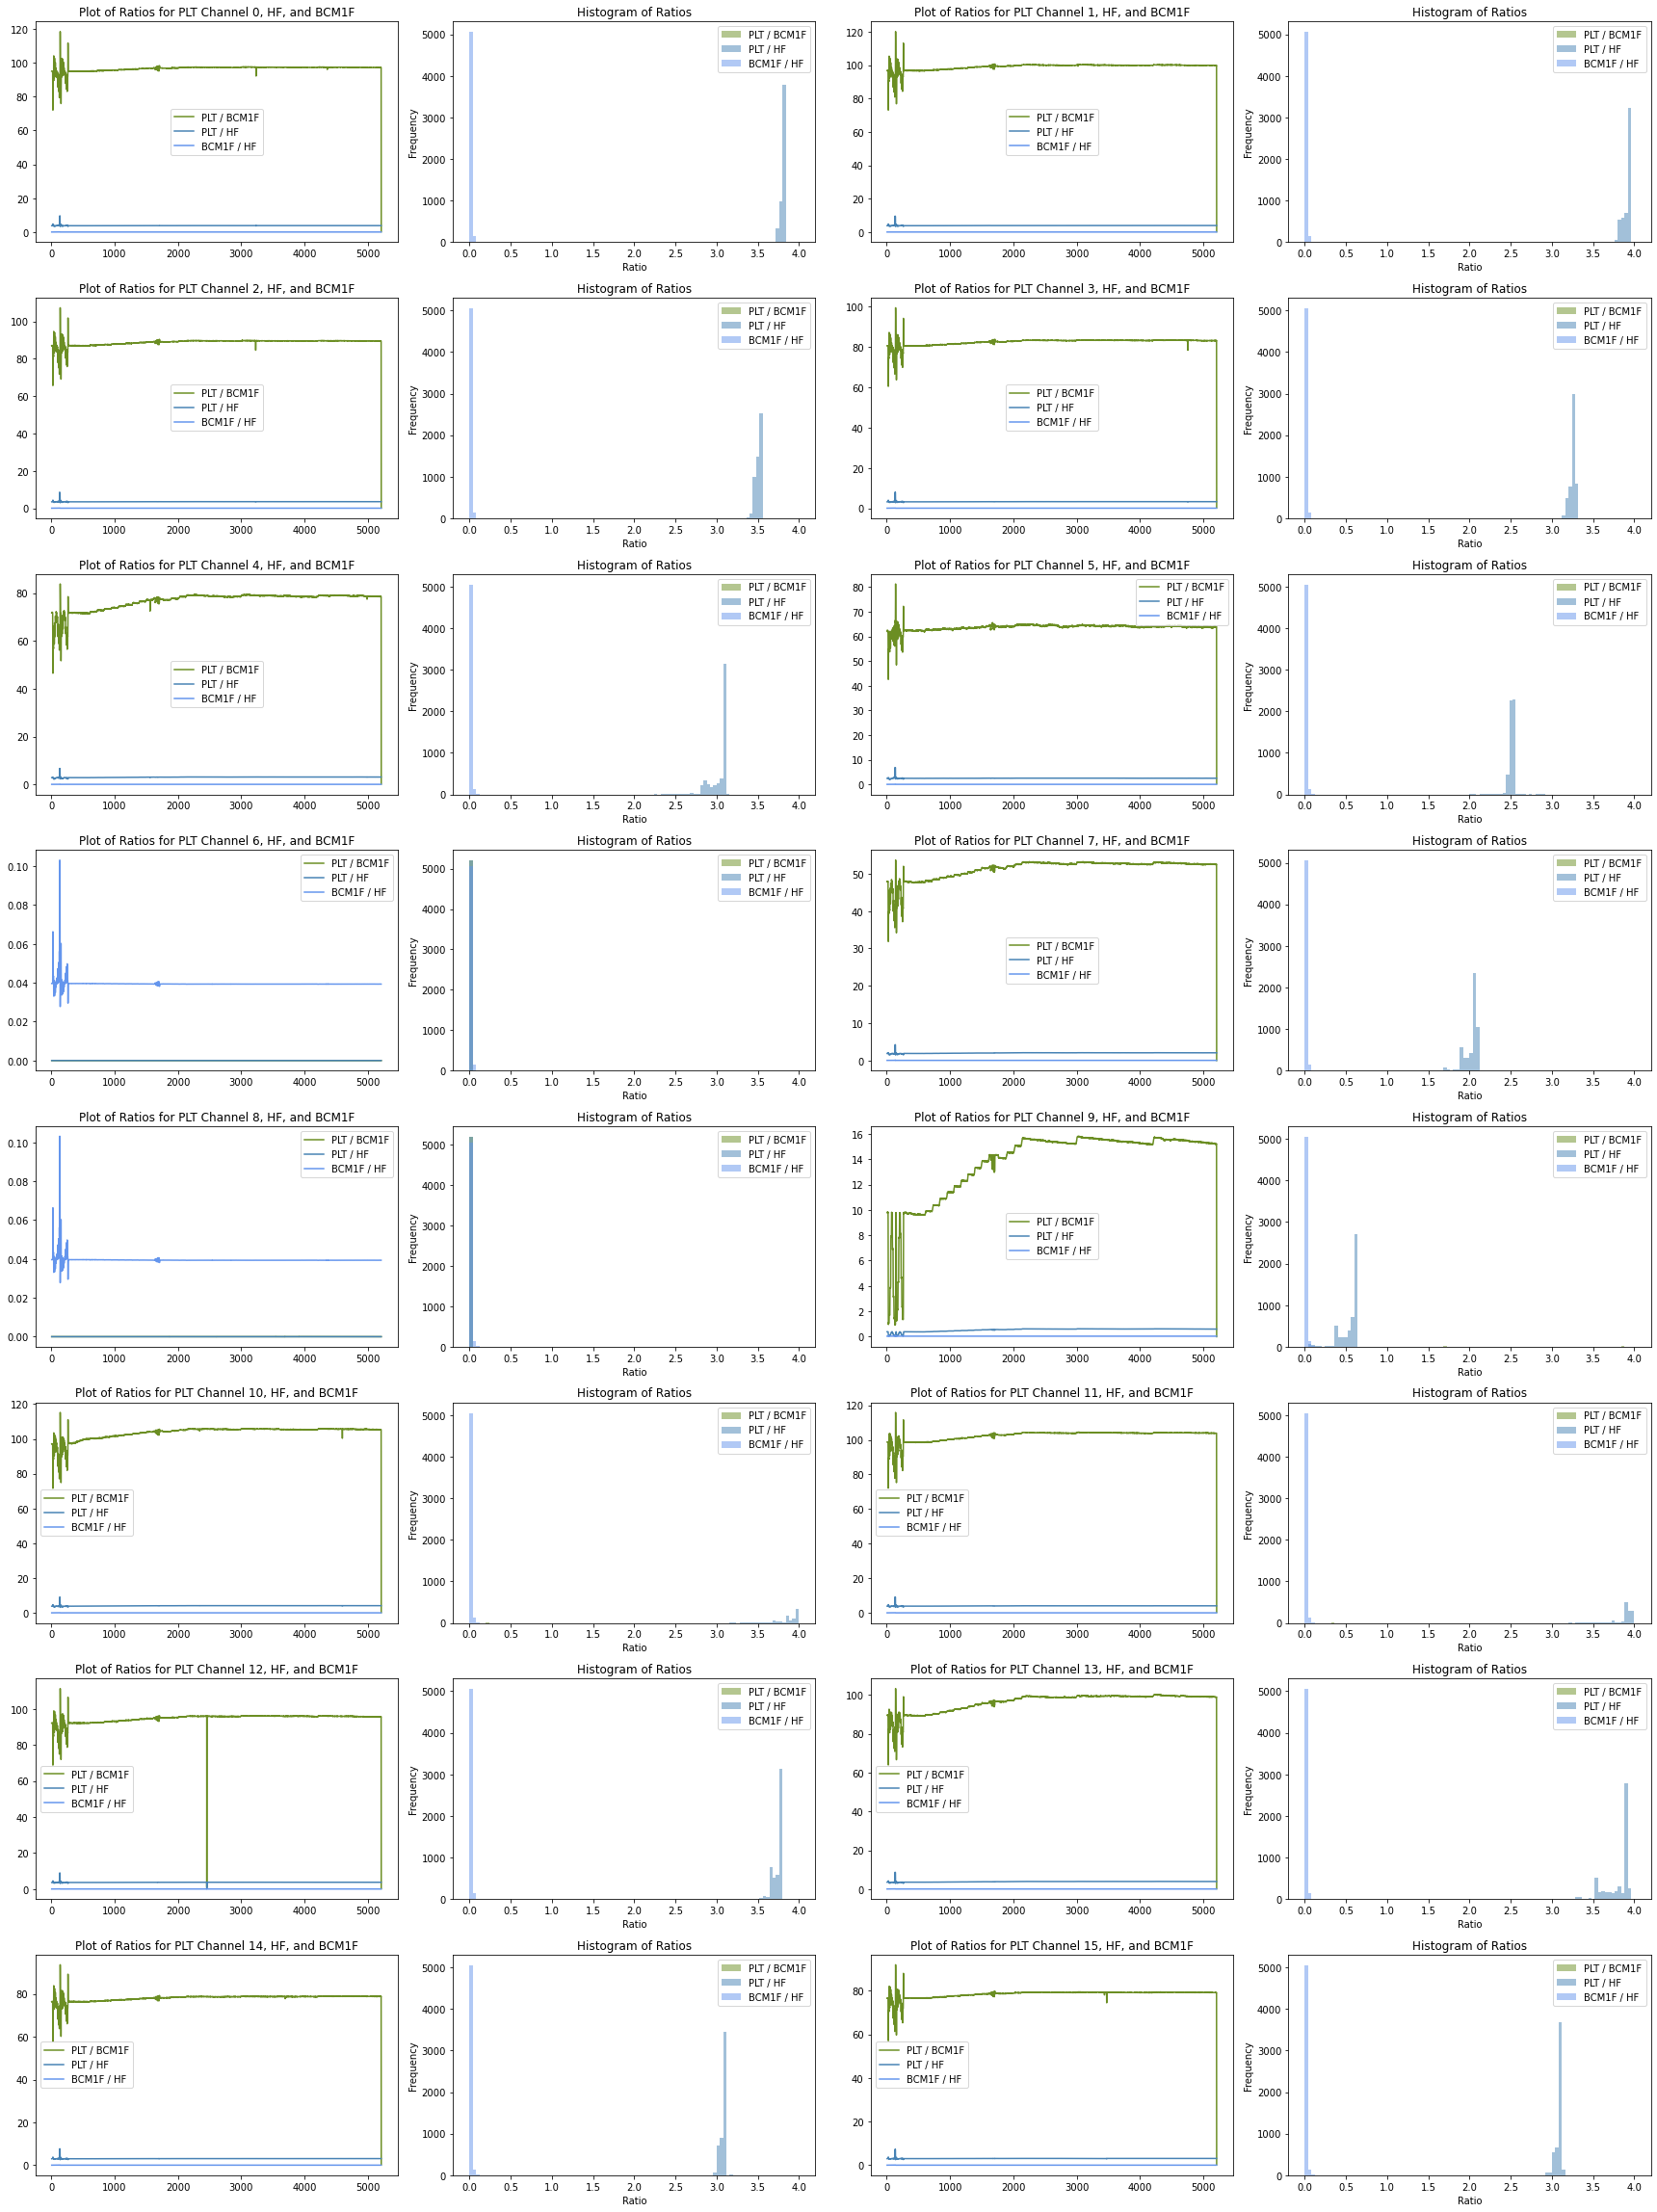

In [105]:
fig, axes = plt.subplots(8, 4, figsize=(24, 32))

for i, ax in enumerate(axes.flatten()):
    channel_index = i // 2
    
    if channel_index >= len(df_data):
        break  
    
    plt_bcm1f = df_data[channel_index].lumi / df_bcm1f
    plt_hf = df_data[channel_index].lumi / df_hf
    bcm1f_hf = df_bcm1f / df_hf
    
    if i % 2 == 0:
        ax.plot(plt_bcm1f, label='PLT / BCM1F', color='olivedrab')
        ax.plot(plt_hf, label='PLT / HF', color='steelblue')
        ax.plot(bcm1f_hf, label='BCM1F / HF', color='cornflowerblue')
        ax.set_title(f"Plot of Ratios for PLT Channel {channel_index}, HF, and BCM1F")
        ax.legend()
    else:
        ax.hist(plt_bcm1f.dropna(), bins=100, alpha=0.5, label='PLT / BCM1F', color='olivedrab', range = (0,4))
        ax.hist(plt_hf.dropna(), bins=100, alpha=0.5, label='PLT / HF', color='steelblue', range = (0,4))
        ax.hist(bcm1f_hf.dropna(), bins=100, alpha=0.5, label='BCM1F / HF', color='cornflowerblue', range = (0,4))
        ax.set_title(f"Histogram of Ratios")
        ax.set_xlabel("Ratio")
        ax.set_ylabel("Frequency")
        ax.legend()

plt.tight_layout()
plt.show()

### There are two versions of the model: the fully automated and the semi-automated version. For generic channel selection I recommend the fully automated option and to look at the trend of anomalies detected as well as their respective histograms. For more intricate anomaly detection use the semi-automated verision. The semi-automated version requires the user to manually verify if certain anomalies are to be kept or thrown out. 

### To interpret what is happening in the graphs, refer to the following below:
    - The two left plots are the plotted differences between luminosity values with the reference dataframe and the individual channel being observed.
    - The two right plots are the luminosity ratios between the reference dataframe and the individual channel being observed.
    - The top two graphs show anomalies flagged from the algorithm. The bottom two plots then find the combined anomalies detected on both the difference and ratio plot and plot those flagged twice.
    

### Each anomaly plot has its own respective histogram documenting the distribution of luminosity values - these shapes should also be taken into account when choosing channels for selection.

### You can select whichever parameter values you'd like depending how intensively selection you'd prefer your model to be. To select more points, either reduce the percent, decrease levelshift, and set window to 1. For a general selection, I recommend the following: 
    - percent: 15 - 25 (we are taking values +- outside this percent window as anomalies)
    - levelshift: 300 - 600
    - window: 1 - 2
    
### Play around parameters here as needed - however I recommend staying within those ranges defined above. Run channel_selection first to see which channels pass inspection and which ones need further inspection.

In [16]:
def round_small_vals(x):
    if np.abs(x) < 0.1:
        return 0

def clean_data(df):
    if isinstance(df, pd.DataFrame):
        first_vals = df.iloc[:300].applymap(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals 
    elif isinstance(df, pd.Series):
        first_vals = df.iloc[:300].apply(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals
    cleaned_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    cleaned_df.dropna(inplace=True)
    return cleaned_df


def detect_anomalies(df, threshold_high, threshold_low, levelshift_c_value, levelshift_window):
    df = clean_data(df)
    df = validate_series(df)
    threshold_ad = ThresholdAD(high=threshold_high, low=threshold_low)
    threshold_anomalies = threshold_ad.detect(df)
    threshold_true_anomalies = threshold_anomalies[threshold_anomalies == True]
    threshold_anomaly_dates = threshold_true_anomalies.index

    level_shift_ad = LevelShiftAD(c=levelshift_c_value, window=levelshift_window)
    levelshift_anomalies = level_shift_ad.fit_detect(df)
    levelshift_true_anomalies = levelshift_anomalies[levelshift_anomalies == True]
    levelshift_anomaly_dates = levelshift_true_anomalies.index
    levelshift_anomalies_all = set(levelshift_anomaly_dates)
    
    combined_anomalies = set(threshold_anomaly_dates).union(levelshift_anomalies_all)
    return combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all
    

def plot_anomalies(ax, df, combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all, channel_number, title):
    def is_scalar(val):
        return isinstance(val, (np.float64, float, int))
    
    def extract_scalar_values(anomaly_dates, anomaly_values):
        scalar_values = []
        valid_dates = []
        removed_indices = []
        
        for date, val in zip(anomaly_dates, anomaly_values):
            if isinstance(val, pd.Series):
                removed_indices.append(len(scalar_values))
                continue
            if is_scalar(val):
                scalar_values.append(val)
                valid_dates.append(date)
        
        return scalar_values, valid_dates, removed_indices
    
    threshold_anomaly_values, threshold_anomaly_valid_dates, threshold_removed_indices = extract_scalar_values(threshold_anomaly_dates, [df.loc[idx] for idx in threshold_anomaly_dates])
    levelshift_anomaly_values, levelshift_anomaly_valid_dates, levelshift_removed_indices = extract_scalar_values(levelshift_anomalies_all, [df.loc[idx] for idx in levelshift_anomalies_all])
    combined_anomaly_values, combined_anomaly_valid_dates, combined_removed_indices = extract_scalar_values(combined_anomalies, [df.loc[idx] for idx in combined_anomalies])
    
    threshold_anomaly_df = pd.DataFrame({'Date': threshold_anomaly_valid_dates, 'Lumi': threshold_anomaly_values})
    levelshift_anomaly_df = pd.DataFrame({'Date': levelshift_anomaly_valid_dates, 'Lumi': levelshift_anomaly_values})
    combined_anomaly_df = pd.DataFrame({'Date': combined_anomaly_valid_dates, 'Lumi': combined_anomaly_values})

    anomaly_dfs = [threshold_anomaly_df, levelshift_anomaly_df, combined_anomaly_df]
    for i, anomaly_df in enumerate(anomaly_dfs, start=0):
        anomaly_df["Date"] = pd.to_datetime(anomaly_df["Date"])
        anomaly_df.set_index("Date", inplace=True)

    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(threshold_anomaly_df.index, threshold_anomaly_df['Lumi'], color='darkmagenta', label='Threshold Anomalies')
    ax.scatter(levelshift_anomaly_df.index, levelshift_anomaly_df['Lumi'], color='hotpink', label='Level Shift Anomalies')
    ax.scatter(combined_anomaly_df.index, combined_anomaly_df['Lumi'], color='darkblue', label='Combined Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.grid(True)

    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    text_str = f"Number of Threshold Anomalies Detected: {len(threshold_anomaly_dates)}\nNumber of Level Shift Anomalies: {len(levelshift_anomalies_all)}\nTotal Anomalies: {len(combined_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)
    

def plot_common_anomalies(ax, df, common_anomalies, channel_number, title):
    common_anomaly_values = [df.loc[idx] for idx in common_anomalies]
    common_anomalies_list = [idx.to_pydatetime() for idx in common_anomalies]
    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(common_anomalies_list, common_anomaly_values, color='green', label='Common Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.legend()
    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    text_str = f"Number of Total Anomalies: {len(common_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

def hist_values(anomaly_values):
    if len(anomaly_values) > 0:
        scalar_values = []
        for val in anomaly_values:
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)

        local_min_val = min(scalar_values)
        local_max_val = max(scalar_values)
        anomaly_vals_large = sorted(scalar_values, reverse=True)[:3]
        anomaly_vals_small = sorted(scalar_values)[:3]
        range_original = local_max_val - local_min_val
        
        filtered_values = [val for val in scalar_values if val not in anomaly_vals_large and val not in anomaly_vals_small]
        if filtered_values:
            filtered_values_max = max(filtered_values)
            filtered_values_min = min(filtered_values)
            range_changed = filtered_values_max - filtered_values_min
        else:
            filtered_values_max = None
            filtered_values_min = None
            
        if len(filtered_values) == 0:
            return local_min_val, local_max_val, pd.Series(dtype=float)
        
        filtered_values = pd.Series(filtered_values, dtype=float)
        return local_min_val, local_max_val, filtered_values
    else:
        return None, None, pd.Series(dtype=float)


def plot_histogram(ax, anomaly_values, channel_number, title):
    if len(anomaly_values) > 0:
        scalar_values = []
        for i, val in enumerate(anomaly_values):
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)
                
        min_val = min(scalar_values)
        max_val = max(scalar_values)
        ax.hist(scalar_values, bins=100, color='blue', edgecolor='black', alpha=0.7, range=(min_val, max_val))
        print(f"Channel {channel_number} - Min Value: {min_val}, Max Value: {max_val}")
        ax.set_xlabel('Luminosity')
        ax.set_ylabel('Frequency')  
        ax.set_title(title)         
        ax.grid(True) 
        print(f"the min and max values calculated here are {min_val} and {max_val}")
        
        return min_val, max_val
    else:
        print(f"Channel {channel_number} has no anomalies to plot.")
        ax.text(0.5, 0.5, "No anomalies detected", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        

def channel_selection(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window, channel_number,
                      df2=None, threshold_high2=None, threshold_low2=None,
                      common_anomalies=None, title1=None, title2=None, title3=None, title4=None):
    def is_infinity(value):
        return math.isinf(value)
    
    threshold_values = [(threshold_high1, threshold_low1), (threshold_high2, threshold_low2)]
    if any(is_infinity(threshold_high) or is_infinity(threshold_low) or math.isnan(threshold_high) or math.isnan(threshold_low)
           for threshold_high, threshold_low in threshold_values):
        print(f"At least one threshold value is infinity or NaN. Channel {channel_number} has failed inspection. \n")
        return
    
    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window)
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_value, levelshift_window)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")
    
    anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
    anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
    anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
    anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
    
    min_val_1, max_val_1, filtered_vals1 = hist_values(anomaly_values1)
    min_val_2, max_val_2, filtered_vals2 = hist_values(anomaly_values2)
    min_val_3, max_val_3, filtered_vals3 = hist_values(anomaly_values3)
    min_val_4, max_val_4, filtered_vals4 = hist_values(anomaly_values4)
    
    
    difference1 = max_val_1 - min_val_1 if max_val_1 is not None and min_val_1 is not None else None
    difference2 = max_val_2 - min_val_2 if max_val_2 is not None and min_val_2 is not None else None
    difference3 = filtered_vals3.max() - filtered_vals3.min() if filtered_vals3 is not None else None
    difference4 = filtered_vals4.max() - filtered_vals4.min() if filtered_vals4 is not None else None
    
    
    print(f"Difference1: {difference1}, Difference2: {difference2}; Difference3: {difference3}, Difference4: {difference4}")
    
    if difference1 is not None and difference1 > 2000:
        if num_common_anomalies >= 100:
            if (difference3 is not None and difference3 > 400) or (difference4 is not None and difference4 > 0.75):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")
    else:
        if num_common_anomalies >= 50:
            if (difference3 is not None and difference3 > 50) or (difference4 is not None and difference4 > 0.35):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")

# Begin Channel Selection 

In [108]:
reference = ch_data[closest_channel]['lumi']
reference_dt = dt_data[closest_channel]

percent = 0.20
levelshift = 400
window = 2

bad_channels = [6, 8, 9]

for channel in channels:
    if channel in bad_channels:
        print(f"Skipping bad channel {channel}. \n")
        continue 
    
    select_channel = channel
    
    if not (len(reference) == len(ch_data[select_channel]['lumi']) == len(reference - ch_data[select_channel]['lumi'])):
        print(f"There is an issue with the lengths for channel {select_channel}") 
        print(f"Length of reference: {len(reference)}")
        print(f"Length of select_channel: {len(ch_data[select_channel]['lumi'])}")
        print(f"Length of channels subtracted: {len(reference - ch_data[select_channel]['lumi'])}")
        continue 

    ch_data[select_channel]['lumi'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ch_data[select_channel]['lumi'].dropna(inplace=True)

    difference = reference - ch_data[select_channel]['lumi']
    difference.index = reference_dt
    difference.index = pd.to_datetime(difference.index).floor('s')

    ratio = (reference / ch_data[select_channel]['lumi'])
    ratio.index = reference_dt
    ratio.index = pd.to_datetime(ratio.index).floor('s')
    ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()
    
    differencemean = np.mean(difference)
    ratiomean = np.mean(ratio)

    threshold_high2 = ratiomean + percent * ratiomean
    threshold_low2 = ratiomean - percent * ratiomean
    
    if differencemean < 0:
        threshold_high1_diff = differencemean - percent * differencemean
        threshold_low1_diff = differencemean + percent * differencemean
    else:
        threshold_high1_diff = differencemean + percent * differencemean
        threshold_low1_diff = differencemean - percent * differencemean

    try:
        channel_selection(difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_value=levelshift, levelshift_window=window, channel_number=select_channel,
                          df2=ratio, threshold_high2=threshold_high2, threshold_low2=threshold_low2, 
                          title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%", title2=f"Reference/{select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%",
                          title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%", title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%")
    except Exception as e:
        print(f"Channel {select_channel} failed inspection with error: {e}. \n")

print(f"{np.random.choice(happy_message)} You just verified fill number {fill_number}.")

Number of common anomalies in Channel 0: 11
Difference1: 4816.042612960027, Difference2: 1.0; Difference3: nan, Difference4: nan
Channel 0 has passed inspection.

Number of common anomalies in Channel 1: 11
Difference1: 5484.7047145901815, Difference2: 1.0; Difference3: nan, Difference4: nan
Channel 1 has passed inspection.

Number of common anomalies in Channel 2: 7
Difference1: 2908.3419375638878, Difference2: 2.0; Difference3: nan, Difference4: nan
Channel 2 has passed inspection.

Number of common anomalies in Channel 3: 5
Difference1: 1486.4957242798228, Difference2: 2.0; Difference3: nan, Difference4: nan
Channel 3 has passed inspection.

Number of common anomalies in Channel 4: 14
Difference1: 1474.4431657027162, Difference2: 2.0; Difference3: nan, Difference4: nan
Channel 4 has passed inspection.

Number of common anomalies in Channel 5: 6
Difference1: 3858.122054057938, Difference2: 0.8; Difference3: nan, Difference4: nan
Channel 5 has passed inspection.

Skipping bad channel 

# Run this code if a channel has failed selection.

0.4722623841287974
Number of common anomalies in Channel 7: 11


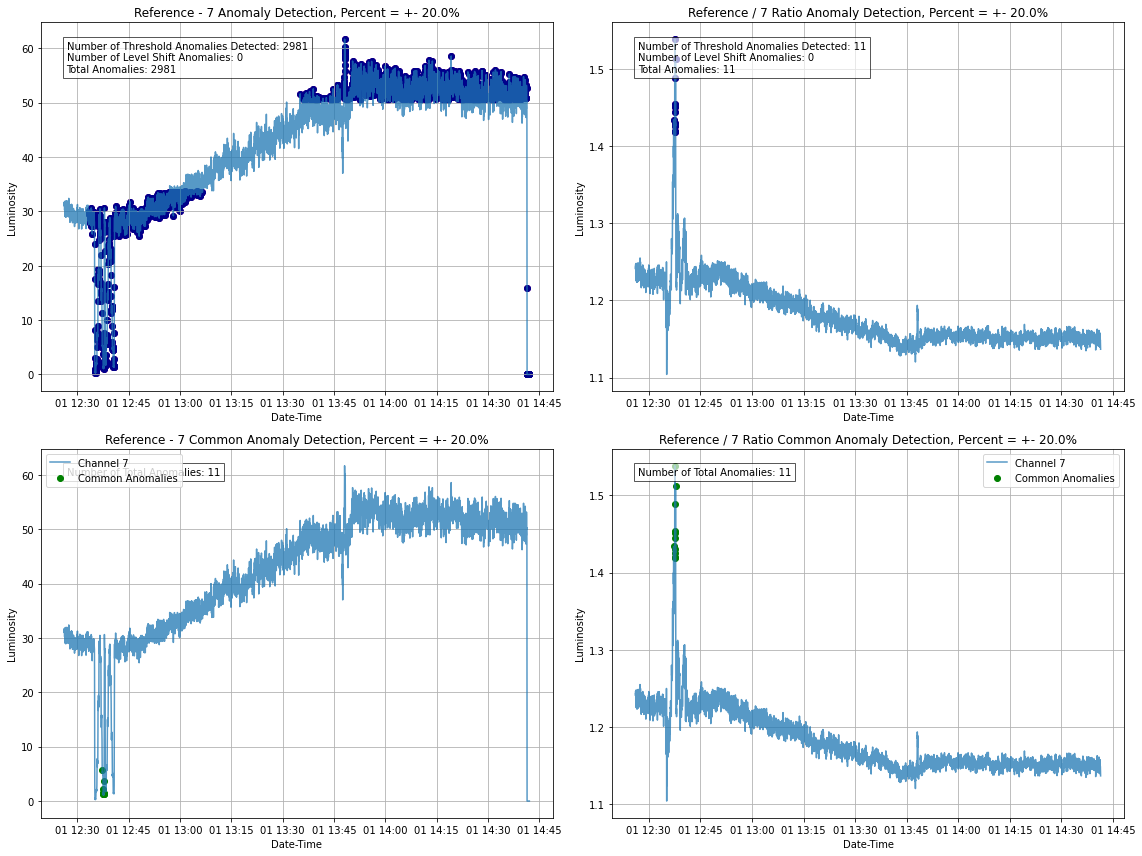

Channel 7 - Min Value: 0.0, Max Value: 61.68918003259313
the min and max values calculated here are 0.0 and 61.68918003259313
Channel 7 - Min Value: 1.418325894691321, Max Value: 1.5383851149249905
the min and max values calculated here are 1.418325894691321 and 1.5383851149249905
Channel 7 - Min Value: 1.2373295750461701, Max Value: 5.720547975707975
the min and max values calculated here are 1.2373295750461701 and 5.720547975707975
Channel 7 - Min Value: 1.418325894691321, Max Value: 1.5383851149249905
the min and max values calculated here are 1.418325894691321 and 1.5383851149249905


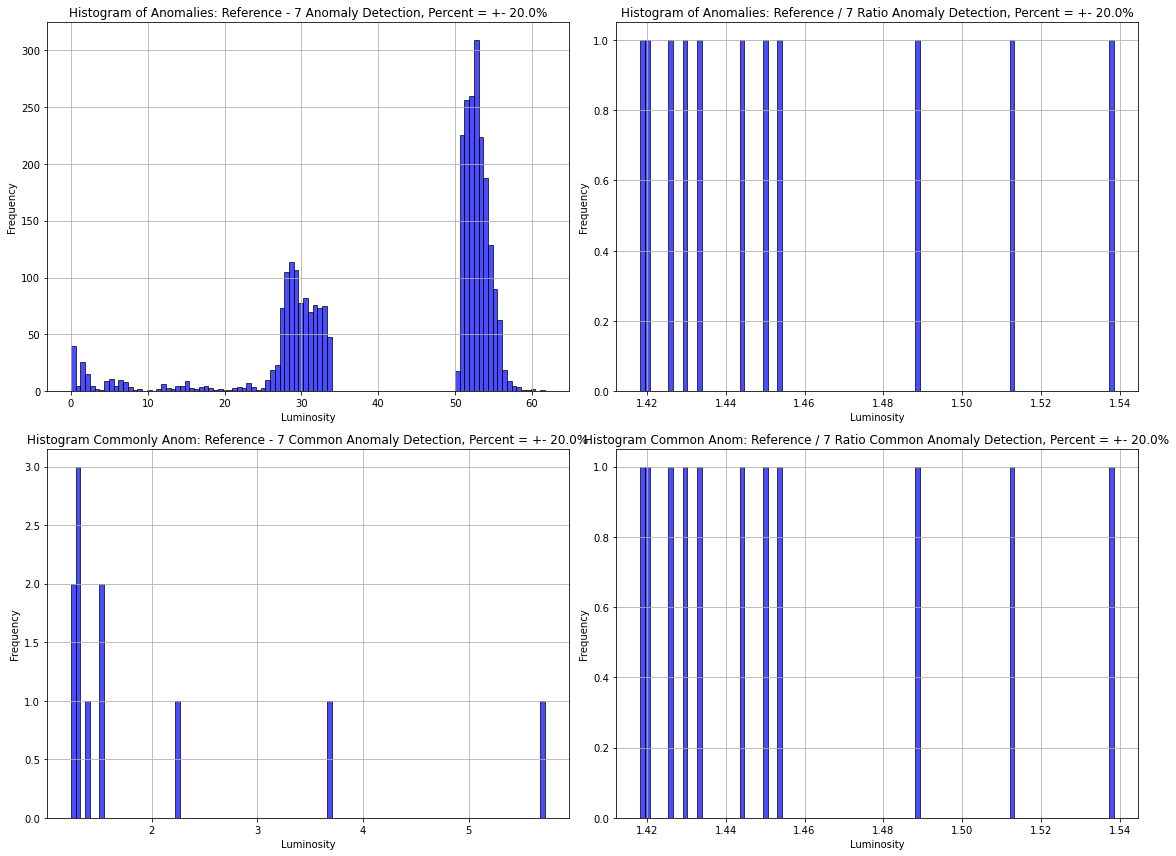

In [94]:
def full_automated(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows, channel_number, df2=None, 
                   threshold_high2=None, threshold_low2=None, common_anomalies=None, title1=None, title2=None, title3=None, title4=None, show_histograms = False):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 0], df1, combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1, channel_number, title1)
    
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 1], df2, combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2, channel_number, title2)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")

    plot_common_anomalies(axs[1,0], df1, common_anomalies, channel_number, title3)
    plot_common_anomalies(axs[1,1], df2, common_anomalies, channel_number, title4)
    plt.tight_layout()
    plt.show()
    
    if show_histograms:
        fig, hist_axes = plt.subplots(2, 2, figsize=(16, 12))

        anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
        plot_histogram(hist_axes[0, 0], anomaly_values1, channel_number, f"Histogram of Anomalies: {title1 if title1 else f'Channel {channel_number}'}")

        anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
        plot_histogram(hist_axes[0, 1], anomaly_values2, channel_number, f"Histogram of Anomalies: {title2 if title2 else f'Channel {channel_number}'}")

        anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 0], anomaly_values3, channel_number, f"Histogram Commonly Anom: {title3 if title3 else f'Channel {channel_number}'}")
        
        anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 1], anomaly_values4, channel_number, f"Histogram Common Anom: {title4 if title4 else f'Channel {channel_number}'}")
        
        plt.tight_layout()
        plt.show()
        
select_channel = 7
difference = reference - ch_data[select_channel]['lumi']
difference.index = reference_dt
difference.index = pd.to_datetime(difference.index).floor('s')

ratio = reference / ch_data[select_channel]['lumi']
ratio.index = reference_dt
ratio.index = pd.to_datetime(ratio.index).floor('s')
ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()

differencemean = np.mean(difference)
ratiomean = np.mean(ratio)

threshold_high2_ratio = ratiomean + percent * ratiomean
threshold_low2_ratio = ratiomean - percent * ratiomean

if differencemean < 0:
    threshold_high1_diff = differencemean - percent * differencemean
    threshold_low1_diff = differencemean + percent * differencemean
else:
    threshold_high1_diff = differencemean + percent * differencemean
    threshold_low1_diff = differencemean - percent * differencemean

    
full_automated(difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_values=levelshift, levelshift_windows=window, channel_number= select_channel,
                           df2=ratio, threshold_high2=threshold_high2_ratio, threshold_low2=threshold_low2_ratio, 
                           title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%", title2=f"Reference / {select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%",
                           title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%", title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%", 
                           show_histograms = True)

# Run this code below to append the data to csv files and to visualize PLT data trends for all previously inspected runs.

In [109]:
processed_fills = []  
hist_year_data = {f"hist_year_data_{ch}": [] for ch in channels} 
dt_data_channel = dt_data[0]
        

def process_fill(fill_number, df_ratio, titles_r):
    if fill_number in processed_fills:
        print(f"Fill number {fill_number} has already been processed.")
        return None
    fig, axes = plt.subplots(4, 4, figsize=(32, 32))
    combined_hist_data = None  
    
    for i, ax in enumerate(axes.flatten()):
        channel = channels[i]
        if channel in channels_failed:
            continue 
        
        median_dt_index = np.round(len(dt_data_channel) / 2).astype(int) 
        median_dt_time = dt_data_channel.iloc[median_dt_index]
        
        valid_data = df_ratio[channel]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
        common_indices = valid_data.index.intersection(dt_data[channel].index)
        valid_data_dt = dt_data[channel].loc[common_indices]
        
        hist_data, bin_edges = np.histogram(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
        hist_year_data[f"hist_year_data_{channel}"].append((hist_data, bin_edges))
        
        if not valid_data.empty:
            ax.hist(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
            ax.set_title(f"Histogram of {titles_r[i]}")
            ax.set_xlabel("Ratio Lumi")
            ax.set_ylabel("Frequency")
            ax.grid(True) 
        else:
            ax.set_title(f"Histogram of {titles_r[i]} (No valid data)")
            ax.set_xlabel("Ratio Lumi")
            ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.close(fig) 
    
    for channel in channels:
        if channel in channels_failed:
            continue  
    
        hist_data_list = hist_year_data[f"hist_year_data_{channel}"]
        all_hist_data = []
        
        for hist_data, bin_edges in hist_data_list:
            for bin_edge, count in zip(bin_edges, hist_data):
                all_hist_data.append({'Bin_Edges': bin_edge, 'Count': count, 'Fill_Number': fill_number, 'Date-Time': median_dt_time})
        
        new_hist_data = pd.DataFrame(all_hist_data)
        channel_filename = f"hist_data_channel_{channel}.csv"
        
        if os.path.exists(channel_filename):
            existing_hist_data = pd.read_csv(channel_filename)
            
            if 'Fill_Number' in existing_hist_data.columns and (existing_hist_data['Fill_Number'] == fill_number).any():
                print(f"Data for fill number {fill_number} in channel {channel} has previously been processed.")
                continue
    
            
            combined_hist_data = pd.concat([existing_hist_data, new_hist_data])
            numeric_cols = combined_hist_data.select_dtypes(include=np.number).columns
            non_numeric_cols = combined_hist_data.select_dtypes(exclude=np.number).columns
            grouped_data = combined_hist_data.groupby('Bin_Edges', as_index=False)[numeric_cols].sum()
            
            if 'Date-Time' in non_numeric_cols:
                non_numeric_data = combined_hist_data[['Bin_Edges', 'Date-Time']].drop_duplicates()
                combined_hist_data = pd.merge(grouped_data, non_numeric_data, on='Bin_Edges', how='left')
            
            print(f"Fill number {fill_number} for channel {channel} has now been processed and appended to other 2023 data.")
        else:
            combined_hist_data = new_hist_data
        
        combined_hist_data.to_csv(channel_filename, index=False)
    
    bcm1f_filename = "bcm1f_data.csv"
    if os.path.exists(bcm1f_filename):
        existing_bcm1f_data = pd.read_csv(bcm1f_filename)
        
        if 'Fill_Number' in existing_bcm1f_data.columns and (existing_bcm1f_data['Fill_Number'] == fill_number).any():
            print(f"Data for fill number {fill_number} in bcm1f_data has previously been processed.")
        else:
            bcm1f_data_to_append = pd.DataFrame(all_hist_data)
            bcm1f_data_to_append['Fill_Number'] = fill_number
            combined_bcm1f_data = pd.concat([existing_bcm1f_data, bcm1f_data_to_append])
            combined_bcm1f_data.to_csv(bcm1f_filename, index=False)
            print(f"Fill number {fill_number} has now been processed and appended to bcm1f_data.")
    else:
        new_hist_data['Fill_Number'] = fill_number
        new_hist_data.to_csv(bcm1f_filename, index=False)
        print(f"Fill number {fill_number} data saved to bcm1f_data.csv.")
    
    hf_filename = "hf_data.csv"
    if os.path.exists(hf_filename):
        existing_hf_data = pd.read_csv(hf_filename)
        
        if 'Fill_Number' in existing_hf_data.columns and (existing_hf_data['Fill_Number'] == fill_number).any():
            print(f"Data for fill number {fill_number} in hf_data has previously been processed.")
        else:
            hf_data_to_append = pd.DataFrame(all_hist_data) 
            hf_data_to_append['Fill_Number'] = fill_number
            combined_hf_data = pd.concat([existing_hf_data, hf_data_to_append])
            combined_hf_data.to_csv(hf_filename, index=False)
            print(f"Fill number {fill_number} has now been processed and appended to hf_data.")
    else:
        new_hist_data['Fill_Number'] = fill_number
        new_hist_data.to_csv(hf_filename, index=False)
        print(f"Fill number {fill_number} data saved to hf_data.csv.")
    processed_fills.append(fill_number)
    return combined_hist_data

result = process_fill(fill_number, df_ratio, titles_r)

Fill number 9059 for channel 0 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 1 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 2 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 3 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 4 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 5 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 7 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 10 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 11 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 12 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 13 has now been processed and appended to other 2023 data.
Fill number 9059 for channel 14 has now

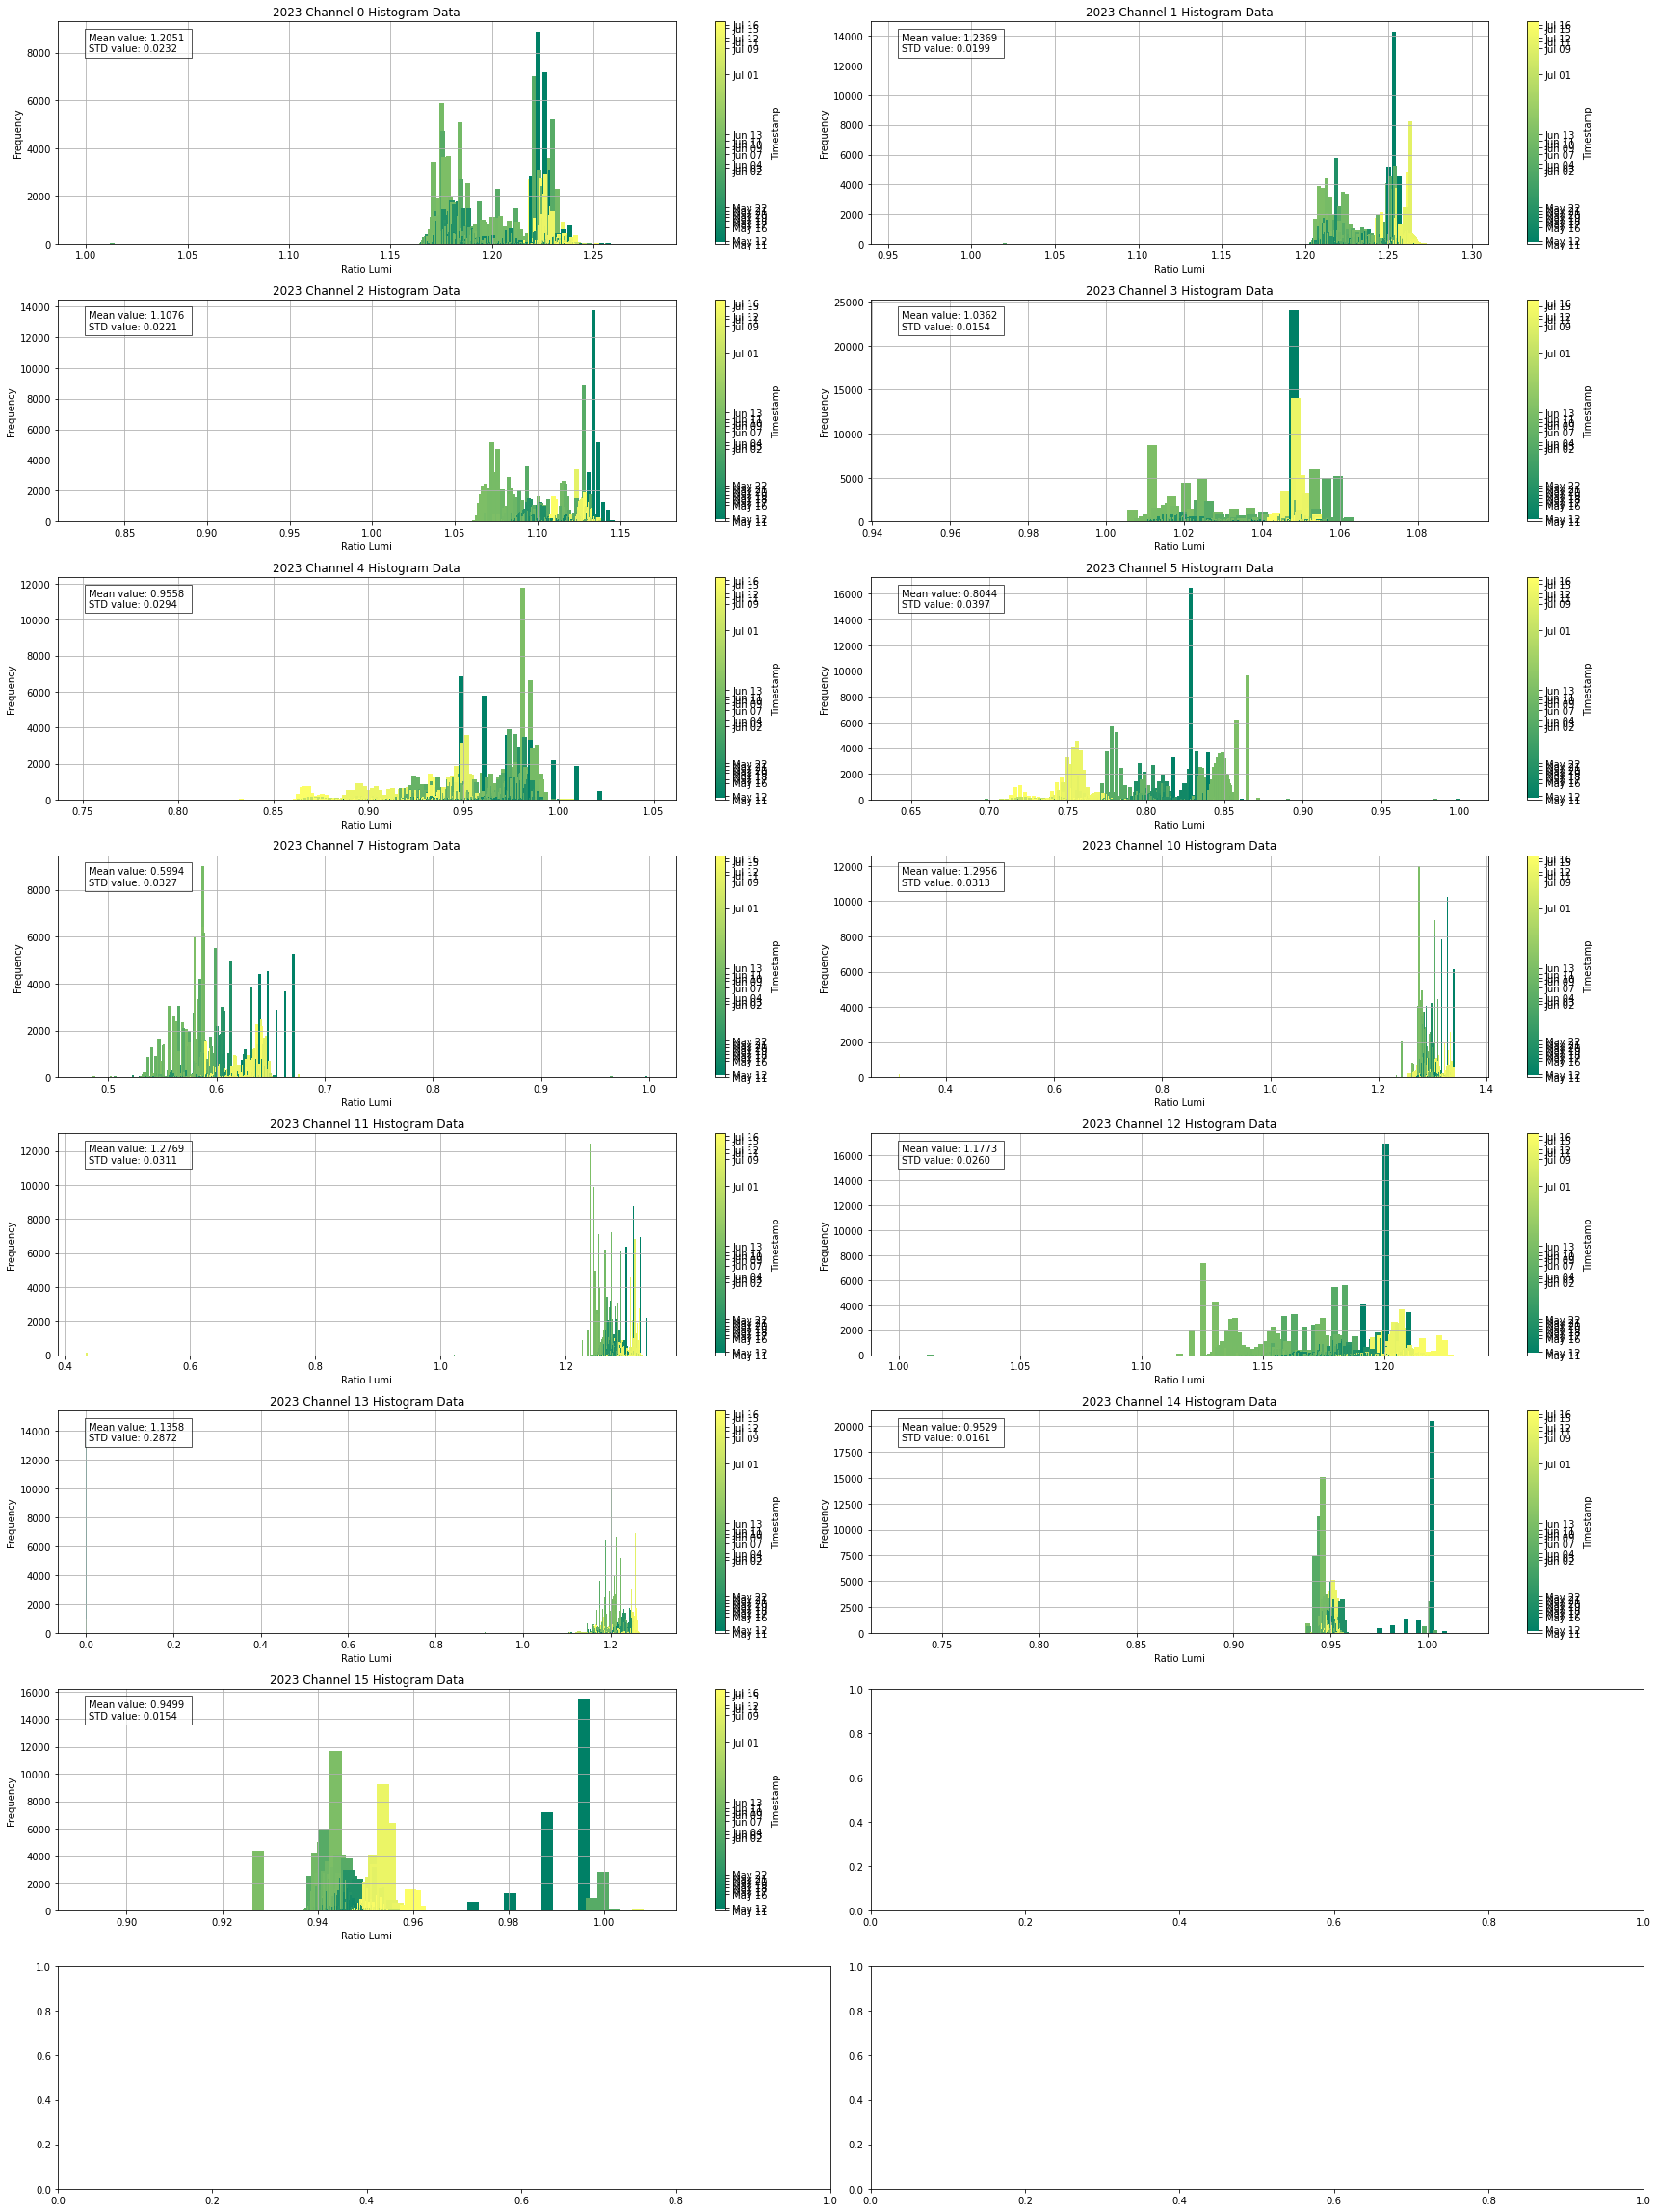

In [5]:
csv_files = [f'hist_data_channel_{ch}.csv' for ch in channels_good]
csv_dfs = []
r_squared_list = []
fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    
    if not filtered_csv.empty:
        filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
        bin_edges = filtered_csv['Bin_Edges']
        counts = filtered_csv['Count']
        
        if counts.sum() == 0:
            print(f"No valid data for fitting Gaussian in channel {channels_good[i]}")
            continue
        
        weighted_sum = (bin_edges * counts).sum()
        total_counts = counts.sum()
        weighted_mean = (weighted_sum / total_counts)
        weighted_variance = (counts * (bin_edges - weighted_mean) ** 2).sum() / total_counts
        weighted_std = np.sqrt(weighted_variance)
        mu_initial = bin_edges.iloc[np.argmax(counts)]
        sigma_initial = np.std(bin_edges)
        min_value = bin_edges.min()
        max_value = bin_edges.max()
        
        df_color = pd.DataFrame({'Date-Time': filtered_csv['Date-Time']})
        df_color['Date-Time'] = pd.to_datetime(df_color['Date-Time'])
        df_color['Timestamp'] = df_color['Date-Time'].astype(np.int64) / 10**9 
        norm = plt.Normalize(df_color['Timestamp'].min(), df_color['Timestamp'].max())
        colormap = plt.cm.summer
        df_color['Color'] = df_color['Timestamp'].apply(lambda x: colormap(norm(x)))

        ax = axes[i]
        bin_width = 0.0025
        ax.bar(bin_edges, counts, width=bin_width, align='edge', color=df_color['Color'])

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax)
        cbar.set_label('Timestamp')
        
        unique_dates = df_color['Date-Time'].dt.date.unique()
        unique_timestamps = [pd.Timestamp(date).timestamp() for date in unique_dates]

        cbar.set_ticks(unique_timestamps)
        cbar.set_ticklabels([pd.to_datetime(ts, unit='s').strftime('%b %d') for ts in unique_timestamps])
         
        ax.set_title(f"2023 Channel {channels_good[i]} Histogram Data")
        ax.set_xlabel("Ratio Lumi")
        ax.set_ylabel("Frequency")
        ax.grid(True)
            
        text_str = f"Mean value: {weighted_mean:.4f} \nSTD value: {weighted_std:.4f}" 
        bbox_props = dict(facecolor='white', alpha=0.65)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

    else:
        print(f"No valid data for fitting Gaussian in channel {channels_good[i]}")
    
plt.tight_layout()
plt.show()

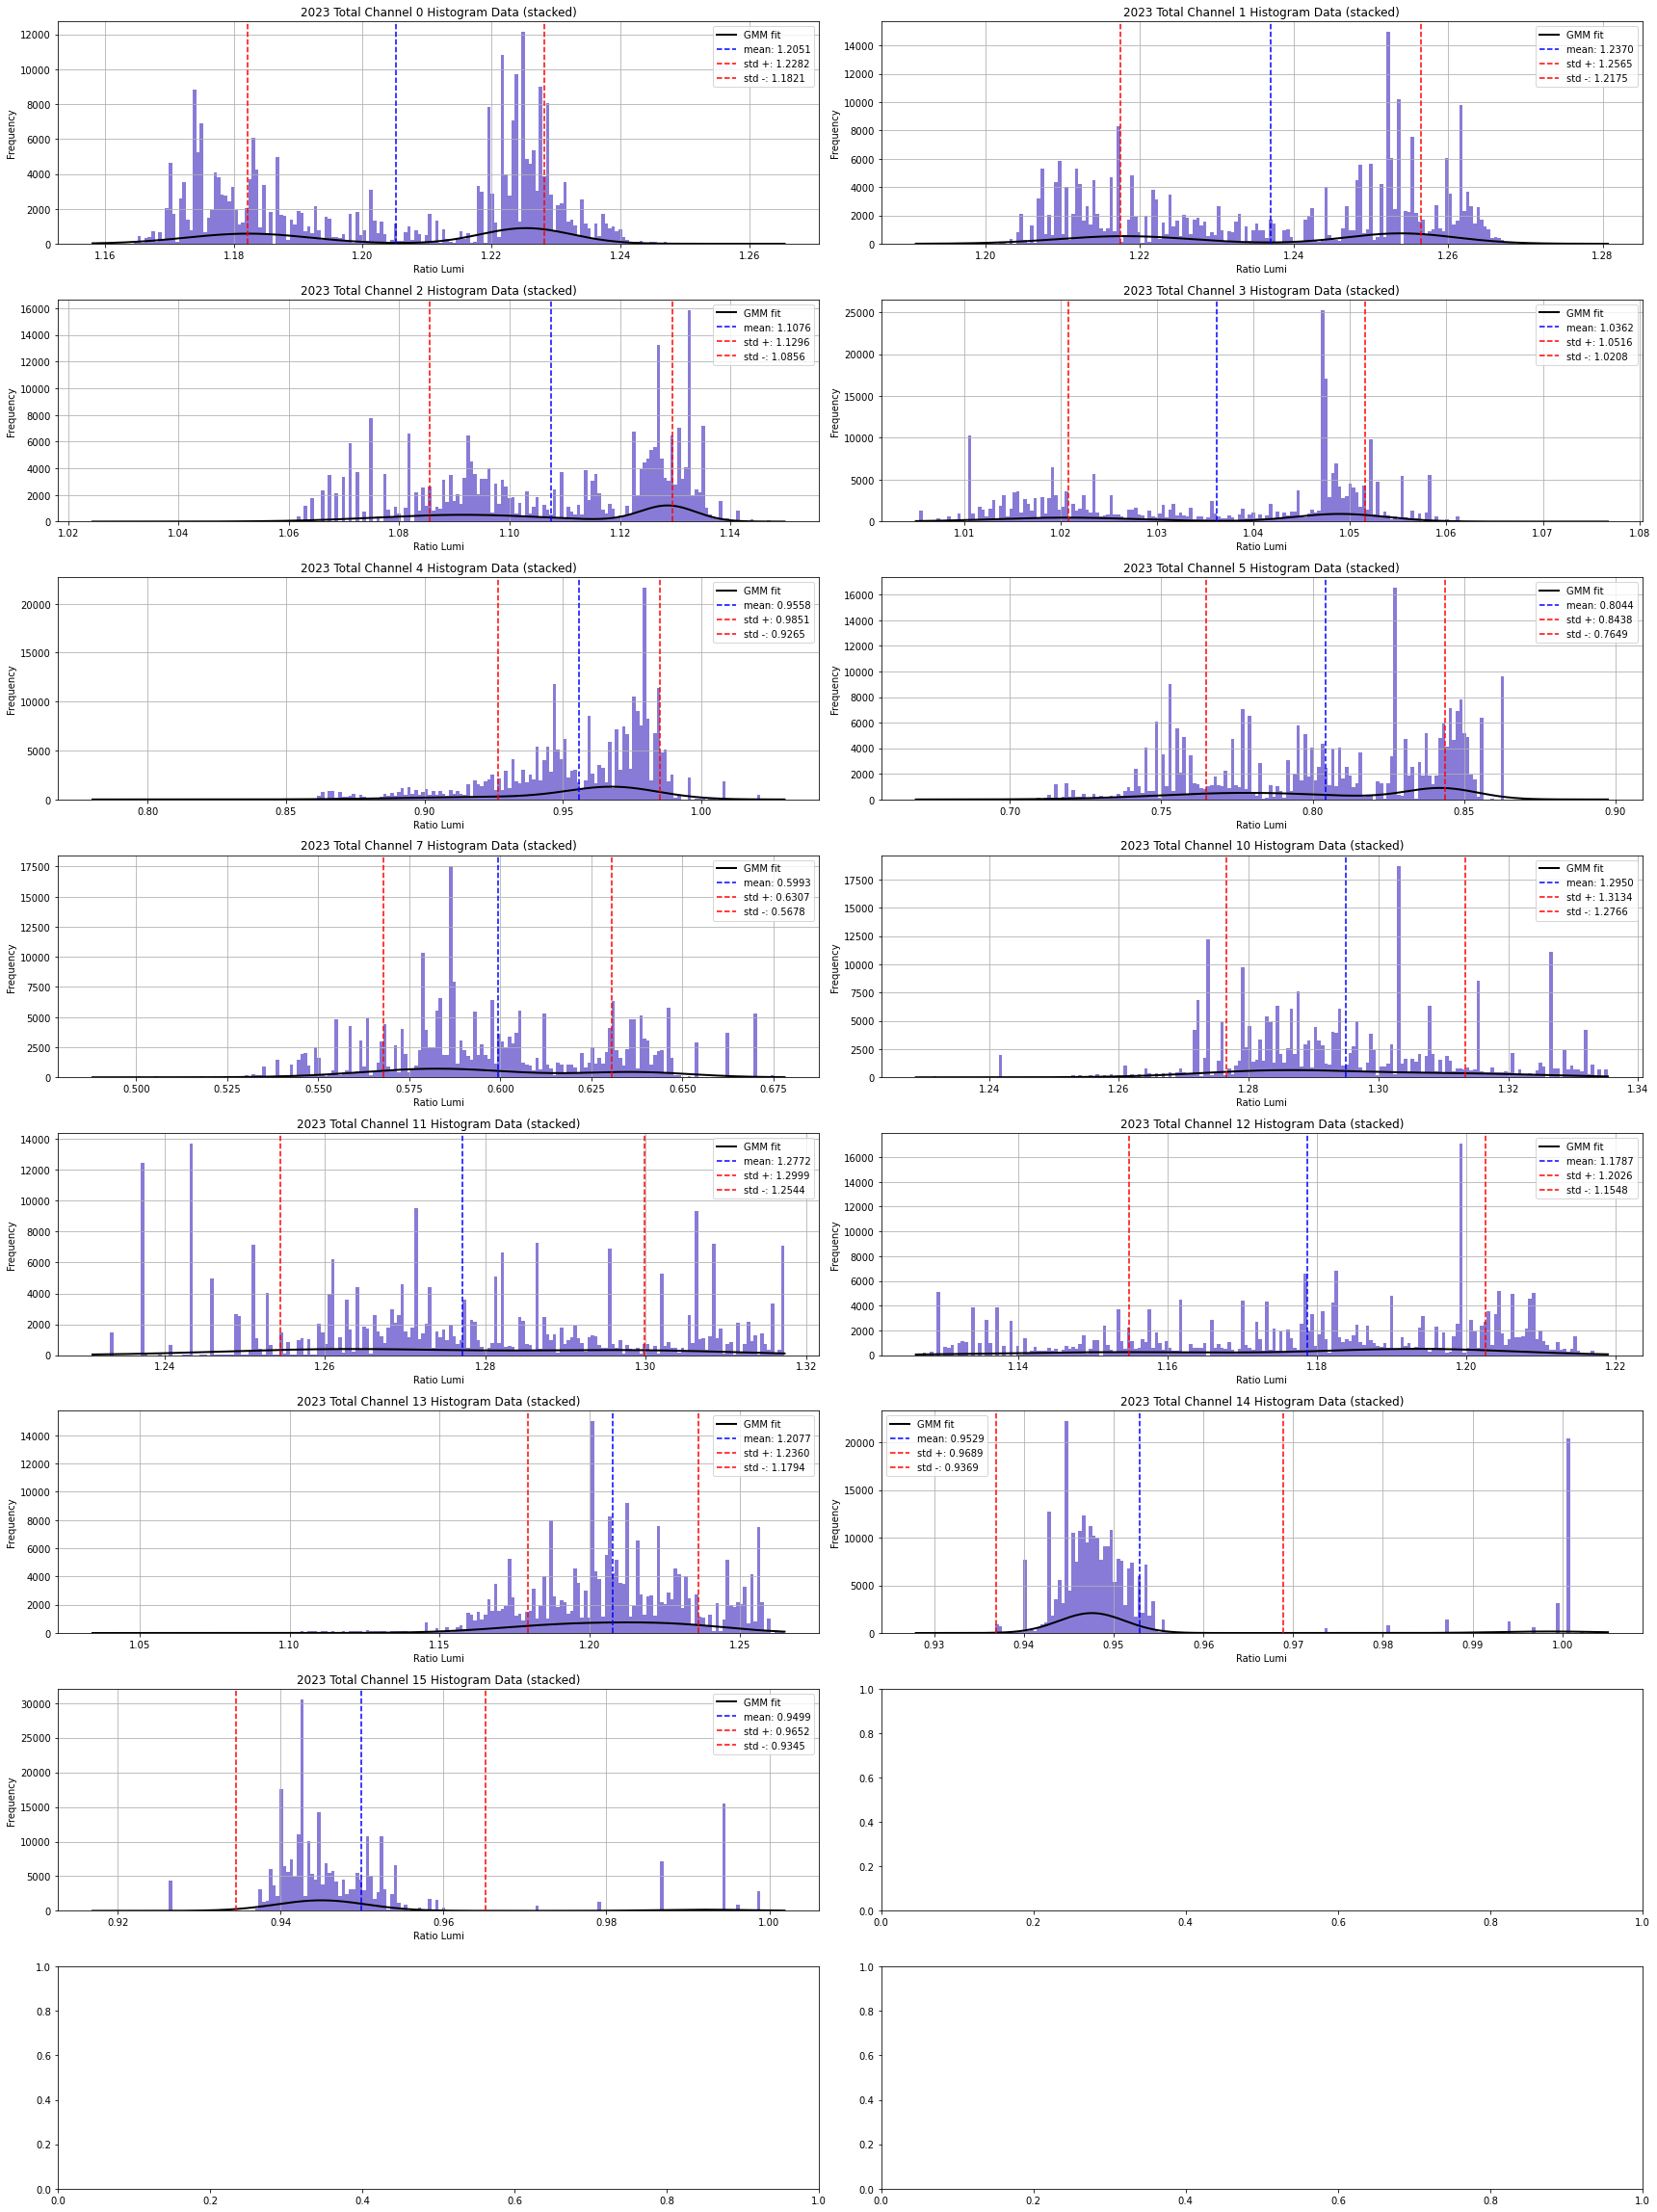

In [6]:
mean_values = []
std_values = []
min_values = []
max_values = []

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

def double_gaussian(x, c1, mu1, sigma1, c2, mu2, sigma2):
    return (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) +
            c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges'].values
    counts = filtered_csv['Count'].values

    bin_vals_large = sorted(bin_edges, reverse=True)[:10]
    bin_vals_small = sorted(bin_edges)[:10]
    bins_to_remove = set(bin_vals_large) | set(bin_vals_small)
    bin_edges_reduced = np.array([value for value in bin_edges if value not in bins_to_remove])
    counts_reduced = np.array([counts[idx] for idx, value in enumerate(bin_edges) if value not in bins_to_remove])

    weighted_sum = (bin_edges_reduced * counts_reduced).sum()
    total_counts = counts_reduced.sum()
    weighted_mean = (weighted_sum / total_counts)
    mean_values.append(weighted_mean)
    weighted_variance = (counts_reduced * (bin_edges_reduced - weighted_mean) ** 2).sum() / total_counts
    weighted_std = np.sqrt(weighted_variance)


    data = np.repeat(bin_edges_reduced[:, np.newaxis], counts_reduced, axis=0) 
    gmm = GaussianMixture(n_components=2, covariance_type='diag')
    gmm.fit(data)

    x = np.linspace(bin_edges_reduced.min(), bin_edges_reduced.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)

    ax = axes[i]
    ax.hist(bin_edges_reduced, bins=200, weights=counts_reduced, color='slateblue', alpha = 0.8)
    ax.plot(x, pdf * counts_reduced.sum() / pdf.sum(), color='black', lw=2, label='GMM fit')

    ax.axvline(x=weighted_mean, linestyle='--', color='b', label=f'mean: {weighted_mean:.4f}')
    ax.axvline(x=weighted_mean + weighted_std, linestyle='--', color='r', label=f'std +: {(weighted_mean + weighted_std):.4f}')
    ax.axvline(x=weighted_mean - weighted_std, linestyle='--', color='r', label=f'std -: {(weighted_mean - weighted_std):.4f}')

    ax.set_xlabel('Ratio Lumi')
    ax.set_ylabel('Frequency')
    ax.set_title(f"2023 Total Channel {channels_good[i]} Histogram Data (stacked)")
    ax.grid(True)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Table Displaying Information Pertaining to PLT Channel Distributions for 2023

In [14]:
spread_values = [max_values[ch] - min_values[ch] for ch in range(len(max_values))]

mean_values_df = pd.DataFrame(mean_values, columns=['Mean'])
std_values_df = pd.DataFrame(std_values, columns=['Std'])
spread_values_df = pd.DataFrame(spread_values, columns=['Spread'])

mean_std = pd.concat([mean_values_df, std_values_df, spread_values_df], axis=1)
mean_std.index = channels_good
mean_std = mean_std.sort_index()

mean_std['Std Low'] = mean_std['Mean'] - mean_std['Std']
mean_std['Std High'] = mean_std['Mean'] + mean_std['Std']

outside_up = []
outside_down = []
percent_error = []

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    filtered_csv = read_csv[(read_csv['Count'] > 1) & read_csv['Date-Time'].notna()]

    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    mean = mean_std.iloc[i]['Mean']
    std = mean_std.iloc[i]['Std']
    
    lower_bound = mean - std
    upper_bound = mean + std
    inside_bounds = (bin_edges >= lower_bound) & (bin_edges <= upper_bound)
    outside_upper = bin_edges > upper_bound
    outside_lower = bin_edges < lower_bound

    counts_inside_sigma = counts[inside_bounds].sum()
    counts_outside_sigma = counts[outside_upper | outside_lower].sum()
    total_counts = counts.sum()

    outside_up.append(counts[outside_upper].sum())
    outside_down.append(counts[outside_lower].sum())

    percentage = 100 * (counts_outside_sigma / total_counts)
    percent_error.append(percentage)

mean_std['Points Above 1 Sigma'] = outside_up
mean_std['Points Below 1 Sigma'] = outside_down
mean_std['Percent Error'] = percent_error
    

html_std = mean_std.to_html(classes='table table-striped', index=True)

html_output = f"""
<div style="width: 80%; margin: 20px auto;">
    <h3 style="text-alicgn: center;">PLT Channel Histogram Data</h3>
    {html_std}
</div>

<style>
    .table {{
        width: 100%;
        border-collapse: collapse;
        margin: 0 auto;
    }}
    .table th, .table td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }}
    .table th {{
        background-color: #f2f2f2;
        font-weight: bold;
    }}
    .table-striped tbody tr:nth-of-type(odd) {{
        background-color: #f9f9f9;
    }}
</style>
"""

display(HTML(html_output))

,Mean,Std,Spread,Std Low,Std High,Points Above 1 Sigma,Points Below 1 Sigma,Percent Error
0,1.205148,0.023059,0.107416,1.182089,1.228207,39684,69894,39.607460
1,1.236988,0.019526,0.089709,1.217462,1.256514,50176,73133,44.574298
2,1.107564,0.021998,0.125375,1.085566,1.129562,56576,56934,41.033742
3,1.036191,0.015414,0.071744,1.020777,1.051605,39067,71380,39.925894
4,0.955827,0.029280,0.249888,0.926546,0.985107,17025,39853,20.560072
5,0.804354,0.039481,0.228681,0.764872,0.843835,60955,61398,44.234795
7,0.599258,0.031440,0.190034,0.567818,0.630699,63093,42551,38.176253
10,1.294957,0.018398,0.106646,1.276559,1.313355,57403,43403,36.426380
11,1.277153,0.022728,0.086292,1.254425,1.299881,61434,55036,42.105149
12,1.178714,0.023931,0.092729,1.154783,1.202645,53238,60831,41.231796


# Visualizing all PLT Channel Distributions Against One Another

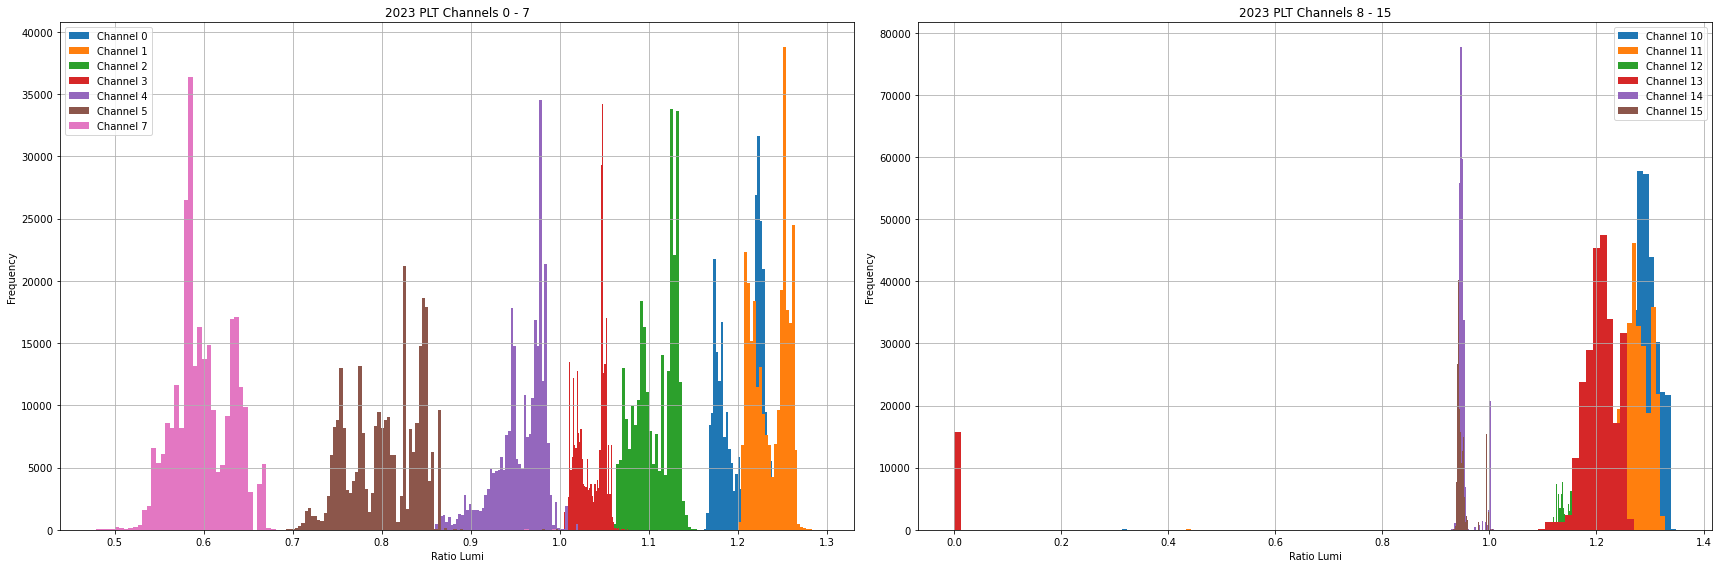

In [7]:
first_half = [0, 1, 2, 3, 4, 5, 6, 7]
second_half = [8, 9, 10, 11, 12, 13, 14, 15]
csv_file_template = "hist_data_channel_{}.csv" 

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for channel in first_half:
    if channel in channels_failed:
        continue
    csv_file = f"hist_data_channel_{channel}.csv"
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    bin_width = 0.005
    axes[0].hist(bin_edges, bins=100, weights=counts, label = f'Channel {channel}')  


for channel in second_half:
    if channel in channels_failed:
        continue
    csv_file = f"hist_data_channel_{channel}.csv"
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    bin_width = 0.005
    axes[1].hist(bin_edges, bins=100, weights=counts, label = f'Channel {channel}')  

axes[0].set_title("2023 PLT Channels 0 - 7")
axes[0].set_xlabel("Ratio Lumi")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)
axes[0].legend(loc='best')

axes[1].set_title("2023 PLT Channels 8 - 15")
axes[1].set_xlabel("Ratio Lumi")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)
axes[1].legend(loc='best')


plt.tight_layout()
plt.show()

# Visualizing PLT Channel Distributions Against BCM1F and HF

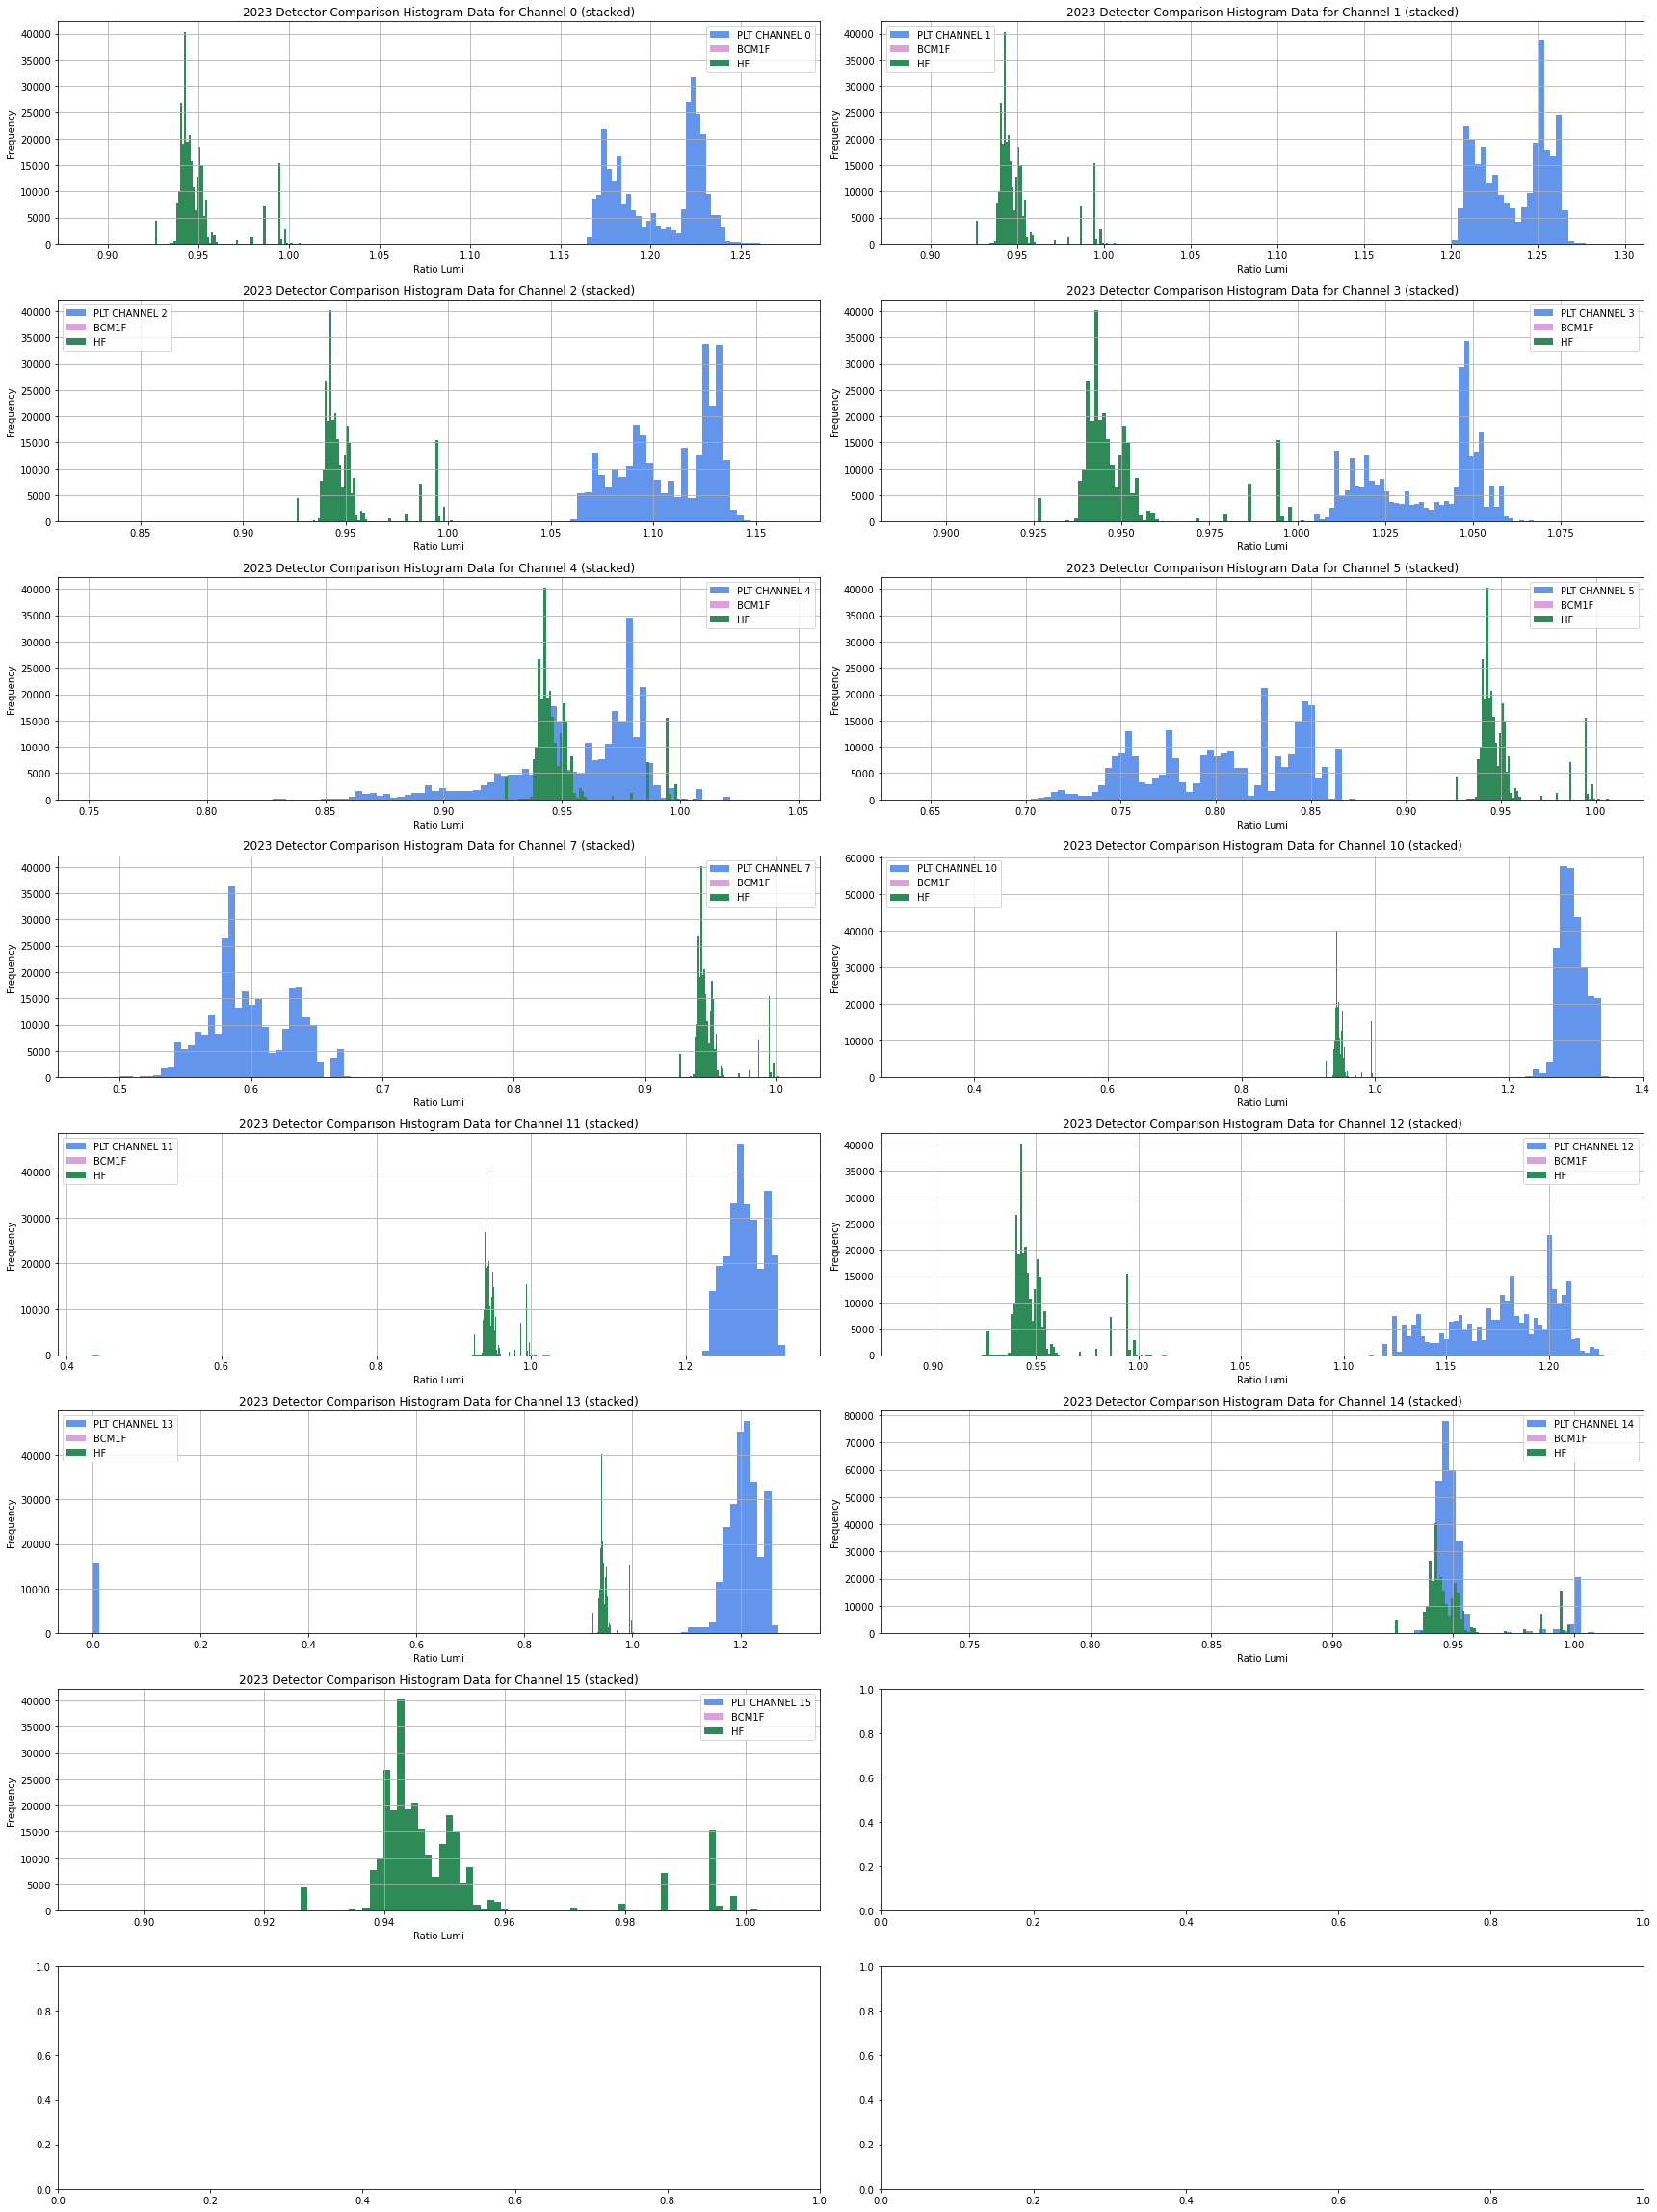

In [8]:
hf_csv = 'hf_data.csv'
bcm1f_csv = 'bcm1f_data.csv'

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    read_bcm1f = pd.read_csv(bcm1f_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    read_hf = pd.read_csv(hf_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    
    filtered_csv_bcm1f = read_bcm1f[read_bcm1f['Count'] > 1]
    filtered_csv_bcm1f = filtered_csv_bcm1f.dropna(subset=['Date-Time'])
    bin_edges_bcm1f = filtered_csv_bcm1f['Bin_Edges']
    counts_bcm1f = filtered_csv_bcm1f['Count']
    
    filtered_csv_hf = read_hf[read_hf['Count'] > 1]
    filtered_csv_hf = filtered_csv_hf.dropna(subset=['Date-Time'])
    bin_edges_hf = filtered_csv_hf['Bin_Edges']
    counts_hf = filtered_csv_hf['Count']

    ax = axes[i]
    ax.hist(bin_edges, bins=100, weights=counts, color='cornflowerblue', label = f'PLT CHANNEL {channels_good[i]}')  
    ax.hist(bin_edges_bcm1f, bins=100, weights=counts_bcm1f, color='plum', label = f'BCM1F')  
    ax.hist(bin_edges_hf, bins=100, weights=counts_hf, color='seagreen', label = f'HF')  
    ax.set_xlabel('Ratio Lumi')
    ax.set_ylabel('Frequency')
    ax.set_title(f"2023 Detector Comparison Histogram Data for Channel {channels_good[i]} (stacked)")
    ax.grid(True)
    ax.legend(loc = 'best')

plt.tight_layout()
plt.show()

# Plot histogram distribution of BCM1F/ HF ratios.

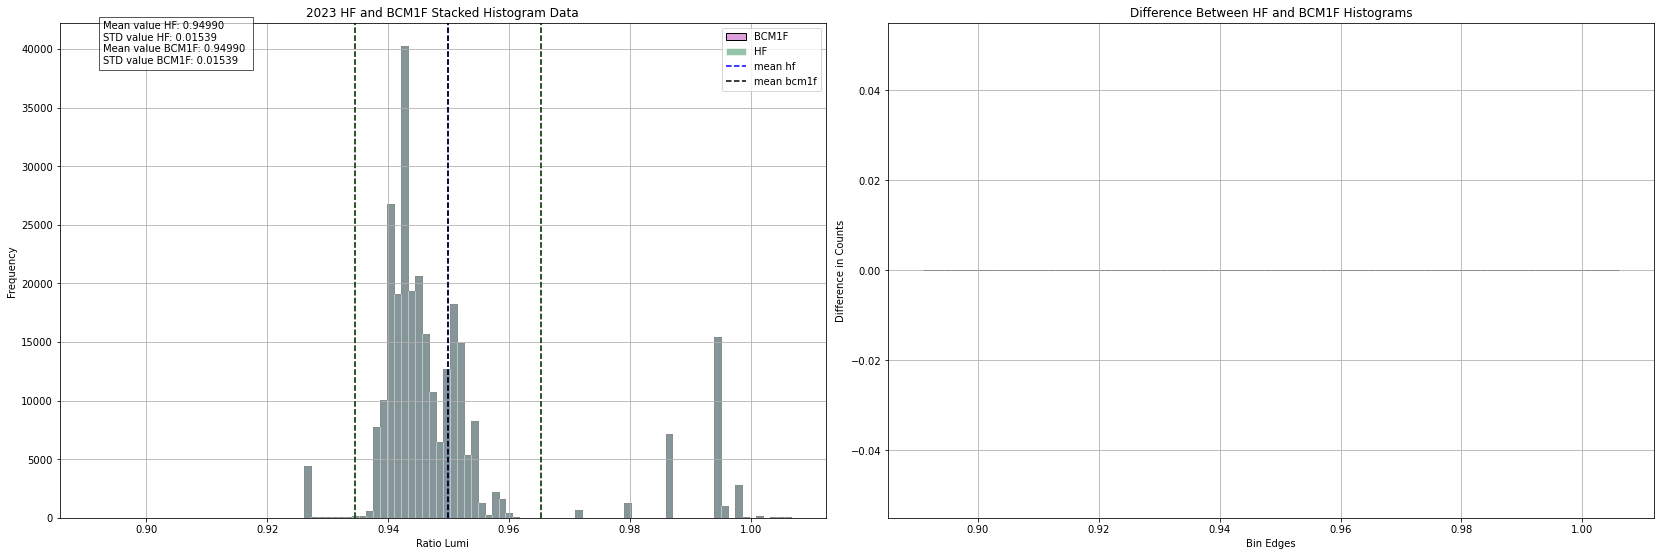

In [15]:
hf_csv = 'hf_data.csv'
bcm1f_csv = 'bcm1f_data.csv'
mean_hf = []
std_hf = []
mean_bcm1f = []
std_bcm1f = []

read_bcm1f = pd.read_csv(bcm1f_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
read_hf = pd.read_csv(hf_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])

filtered_csv_bcm1f = read_bcm1f[read_bcm1f['Count'] > 1]
filtered_csv_bcm1f = filtered_csv_bcm1f.dropna(subset=['Date-Time'])
bin_edges_bcm1f = filtered_csv_bcm1f['Bin_Edges']
counts_bcm1f = filtered_csv_bcm1f['Count']

filtered_csv_hf = read_hf[read_hf['Count'] > 1]
filtered_csv_hf = filtered_csv_hf.dropna(subset=['Date-Time'])
bin_edges_hf = filtered_csv_hf['Bin_Edges']
counts_hf = filtered_csv_hf['Count']

bin_number = 100
bins = np.histogram_bin_edges(np.concatenate([bin_edges_bcm1f, bin_edges_hf]), bins=bin_number)

counts_bcm1f_hist, _ = np.histogram(bin_edges_bcm1f, bins=bins, weights=counts_bcm1f)
counts_hf_hist, _ = np.histogram(bin_edges_hf, bins=bins, weights=counts_hf)
difference_counts = counts_hf_hist - counts_bcm1f_hist


weighted_sum_hf = (bin_edges_hf * counts_hf).sum()
total_counts_hf = counts_hf.sum()
weighted_mean_hf = (weighted_sum_hf / total_counts_hf)
mean_hf.append(weighted_mean)
weighted_variance_hf = (counts_hf * (bin_edges_hf - weighted_mean_hf) ** 2).sum() / total_counts_hf
weighted_std_hf = np.sqrt(weighted_variance_hf)
std_hf.append(weighted_std_hf)

weighted_sum_bcm1f = (bin_edges_bcm1f * counts_bcm1f).sum()
total_counts_bcm1f = counts_bcm1f.sum()
weighted_mean_bcm1f = (weighted_sum_bcm1f / total_counts_bcm1f)
mean_bcm1f.append(weighted_mean_bcm1f)
weighted_variance_bcm1f = (counts_bcm1f * (bin_edges_bcm1f - weighted_mean_bcm1f) ** 2).sum() / total_counts_bcm1f
weighted_std_bcm1f = np.sqrt(weighted_variance_bcm1f)
std_bcm1f.append(weighted_std_bcm1f)


fig, axes = plt.subplots(1, 2, figsize=(24, 8))

axes[0].hist(bin_edges_bcm1f, bins=bin_number, weights=counts_bcm1f, color='plum', edgecolor='black', label = f'BCM1F', alpha = 1)  
axes[0].hist(bin_edges_hf, bins=bin_number, weights=counts_hf, color='seagreen', edgecolor='white', label = f'HF', alpha = 0.5)
axes[0].axvline(x=weighted_mean_hf, linestyle='--', color='b', label='mean hf')
axes[0].axvline(x=weighted_mean_hf + weighted_std_hf, linestyle = '--', color = 'darkmagenta')
axes[0].axvline(x=weighted_mean_hf - weighted_std_hf, linestyle = '--', color = 'darkmagenta')

axes[0].axvline(x=weighted_mean_bcm1f, linestyle='--', color='black', label='mean bcm1f')
axes[0].axvline(x=weighted_mean_bcm1f + weighted_std_bcm1f, linestyle = '--', color = 'darkgreen')
axes[0].axvline(x=weighted_mean_bcm1f - weighted_std_bcm1f, linestyle = '--', color = 'darkgreen')

axes[0].set_xlabel('Ratio Lumi')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f"2023 HF and BCM1F Stacked Histogram Data")
axes[0].grid(True)
axes[0].legend(loc = 'best')

axes[1].bar(bins[:-1], difference_counts, width=np.diff(bins), color='grey', edgecolor='black')

axes[1].set_xlabel('Bin Edges')
axes[1].set_ylabel('Difference in Counts')
axes[1].set_title('Difference Between HF and BCM1F Histograms')
axes[1].grid(True)

text_str = f"Mean value HF: {weighted_mean_hf:.5f} \nSTD value HF: {weighted_std_hf:.5f} \nMean value BCM1F: {weighted_mean_bcm1f:.5f} \nSTD value BCM1F: {weighted_std_bcm1f:.5f}"
bbox_props = dict(facecolor='white', alpha=0.65)
axes[0].text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

plt.tight_layout()